In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

df = pd.read_csv('../../data/data.csv')
df.rename(columns={'CAMPAIGN_TYPE ':'CAMPAIGN_TYPE', 'FREE TRIALS': 'FREE_TRIALS'}, inplace=True)
df

,REPORT_DATE,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE_TRIALS
0,6/9/2023,DR - Direct Response,Title,paid social,7784.31,86401.15
1,8/29/2023,DR - Direct Response,Title,app,2474.31,2956.74
2,7/23/2023,ATL - Above The Line,Title,paid social,10222.82,12513.08
3,12/23/2023,DR - Direct Response,Title,app,49631.87,17207.04
4,8/31/2022,ATL - Above The Line,Title,paid social,2081.06,21758.33
...,...,...,...,...,...,...
14103,2/23/2024,ATL - Above The Line,Brand,bvod,1478.78,16941.67
14104,4/21/2024,ATL - Above The Line,Title,ooh,839.25,5727.03
14105,12/13/2023,ATL - Above The Line,Title,bvod,193796.71,34824.51
14106,2/4/2023,ATL - Above The Line,Brand,paid social,84690.65,25140.77


In [362]:
'''
1. Data Types Breakdown:
    a. REPORT_DATE: Numerical | (Discrete -> Interval -> DateTime object)
    b. ATL_OR_DR: Categorical | (Nominal  -> String)
    c. CAMPAIGN_TYPE: Categorical | (Nominal -> String)
    d. CHANNEL: Categorical | (Nominal -> String)
    e. COST: Quantitative | (Continuous -> Ratio -> Float)
    f. FREE TRAILS: Quantitative | ( Continuous -> Ratio -> Float)

2. Data Questions/Concerns:
    a. Is 'FREE TRAILS' a generated impression count from another model? How does a a free trial
    lead to continous values instead of discrete?

=> Action Items:
    a. Ensure proper data types across dataframe - DONE
    b. Identify missing data gaps - DONE
    c. Decide on encoding strategy for categorical data - DONE
'''
colNames = df.columns
categorical = colNames[1:4].values.tolist()
quantitative = colNames[4::].values.tolist()

df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])

# Add the Super Bowl dates to the holiday list - assumption being that there are heavy promotions during this time
us_holidays = holidays.US()
super_bowl_dates = ["2022-02-13", "2023-02-12", "2024-02-11"]
for date in super_bowl_dates:
    us_holidays[date] = "Super Bowl"
df['HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: x in us_holidays if pd.notnull(x) else False)
df['LAG_3_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x + pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 4)) if pd.notnull(x) else False)
df['LEAD_3_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x - pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 4)) if pd.notnull(x) else False)

# Extract the month and season from the date
month_to_season = {
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
    12: "Winter"
}
df['SEASON'] = df['REPORT_DATE'].dt.month.map(month_to_season)
df['MONTH'] = df['REPORT_DATE'].dt.month_name()

# Combine categories for feature engineering
df['CHANNEL_ATL_OR_DR'] = df['CHANNEL'] + '_' + df['ATL_OR_DR']
df['CHANNEL_CAMPAIGN_TYPE'] = df['CHANNEL'] + '_' + df['CAMPAIGN_TYPE']
categorical.extend(['HOLIDAY_FLAG', 'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG',
                    'SEASON', 'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'MONTH'])

# Combine numerical data for feature engineering
df['COST_PER_FREE_TRIALS'] = df['COST'] / df['FREE_TRIALS']
df['COST_BY_FREE_TRIALS'] = df['COST'] * df['FREE_TRIALS']
quantitative.extend(['COST_PER_FREE_TRIALS','COST_BY_FREE_TRIALS'])

# Results
print(f'Categorical | {len(categorical)}: {categorical}\nQuantitative | {len(quantitative)}: {quantitative} \n')
print(f'Table Dimension: {df.shape} \n')
df.info()

Categorical | 10: ['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'HOLIDAY_FLAG', 'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG', 'SEASON', 'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'MONTH']
Quantitative | 4: ['COST', 'FREE_TRIALS', 'COST_PER_FREE_TRIALS', 'COST_BY_FREE_TRIALS'] 

Table Dimension: (14108, 15) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   REPORT_DATE            14108 non-null  datetime64[ns]
 1   ATL_OR_DR              14108 non-null  object        
 2   CAMPAIGN_TYPE          14108 non-null  object        
 3   CHANNEL                14108 non-null  object        
 4   COST                   14108 non-null  float64       
 5   FREE_TRIALS            14108 non-null  float64       
 6   HOLIDAY_FLAG           14108 non-null  bool          
 7   LAG_3_HOLIDAY_FLAG     14108 non-null  bool    

### Univariate Analysis on Continuous Data

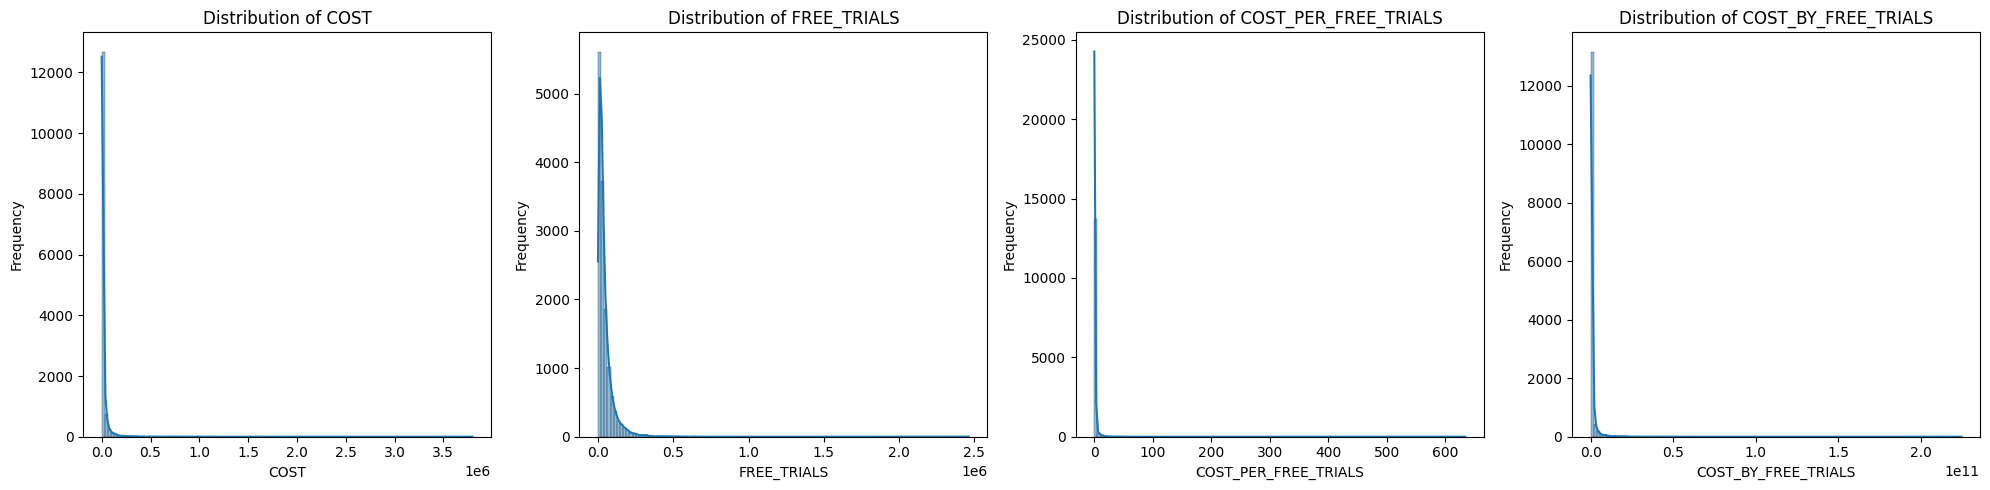

,COST,FREE_TRIALS,COST_PER_FREE_TRIALS,COST_BY_FREE_TRIALS
count,1.410800e+04,1.410800e+04,14108.000000,1.410800e+04
mean,1.655741e+04,4.545834e+04,0.964311,7.898312e+08
std,7.359892e+04,6.040529e+04,7.217306,4.949440e+09
min,0.000000e+00,5.762400e+02,0.000000,0.000000e+00
25%,9.457675e+02,1.393528e+04,0.028652,2.165098e+07
50%,3.164070e+03,2.777694e+04,0.113137,8.822948e+07
75%,1.064149e+04,5.467904e+04,0.469016,3.538239e+08
max,3.798940e+06,2.463082e+06,634.101017,2.245760e+11


In [392]:
'''
Single Variation Continuous Analysis using Histogram with 118 bins | bin size ~= SqRoot(n):

1. All visuals shows a right skewed distribution with outliers on the right side. So, the mean will be greater than the median.
2. All visuals show data points are clustered around the lower ends and extreme outliers causing the positive skewness.
3. The max values for all data, (COST = 3M, FREE_TRIALS = 2M), are significantly larger than the  (IQR) and mean values,
confirming the presence of extreme outliers. More analysis is needed to determine if these should be removed or kept.
4. With such skewness, median would be a more viable measure of central tendency than the mean.
5. COST_PER_FREE_TRIALS has a median value of 0.11, which means the majority of free trials cost only a small amount. Because of positive
skewness, the mean value, .96, is significantly larger due to these outlier campaigns costing drastically more than the majority of the data.
6. Most of the cluster of COST is around 0 which is surprising because I wouldn't have guessed the majority of campaigns to incur 0 expenses.
Is 0 a placeholder for missing data?
7.  All visuals violates Linear Regression's assumption of normality. Need to log transform this feature to normalize the data and reduce outlier
impact
8. FREE TRIALS has a broader distribution of values giving comapnies who go live with campaigns to really optimize their campaign stratgey
because of this wide range. This also signals the fact that some campaigns can fail and genterate minimal free trials. This can also present
many use cases for A/B testing to see what works and what doesn't.
9. COST is more concentrated near zero with minimal campaigns incuring high expenses. This tell us that it's either relatively inexpensive and
consistent when it comes the cost of runnning a campaign or companies aren't allocating enough to run campaigns. Becaeuse the concentration of
COST are similar but FREE TRIALS isn't, we can infer that COST isn't soely the driving factor in creating FREE TRIALS and in fact there are other
factors in pay.
10. The lowest free trial generated for a campaign is 500. Interesting it's not 0 unlike COST. Is 500 suppose to repersent 0?

=> Action Items:
    a. Log Transformation on 'COST' and 'FREE TRIALS'. - DONE
    b. Single Variation Continuous Analysis using boxplots - DONE
    c. Covaritation Continuous Analysis between 'COST' and 'FREE TRIALS' using a scatterplot. - DONE
    d. Validate assumption that cost and free trials doesn't have a strong linear relationship. - DONE
'''
# Create a grid layout
num_cols = len(quantitative)
ncols = 4  # Set the number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically based on total columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))  # Wider figure for 4 columns

# Plot each quantitative column
for i, quant_col in enumerate(quantitative):
    sns.histplot(df[quant_col], kde=True, bins=118, ax=axes[i])
    axes[i].set_title(f'Distribution of {quant_col}')
    axes[i].set_xlabel(quant_col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

df[quantitative].describe()


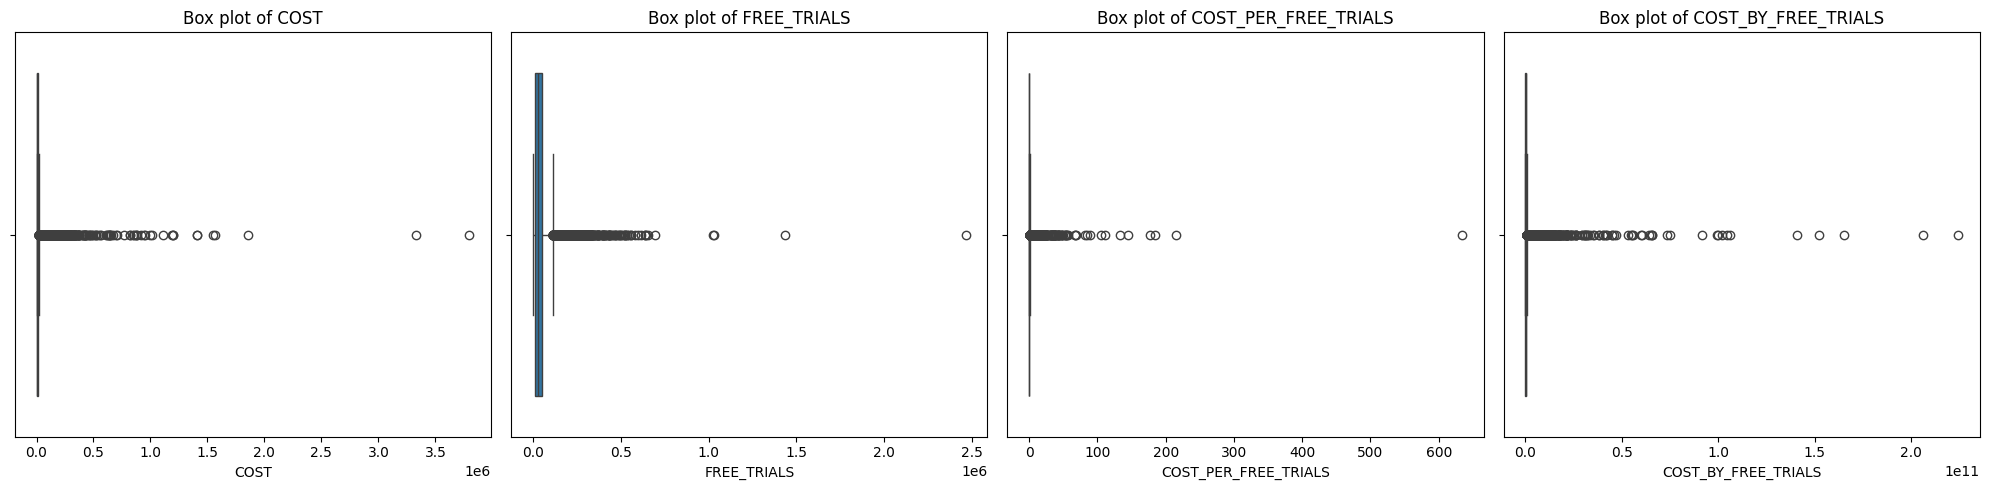

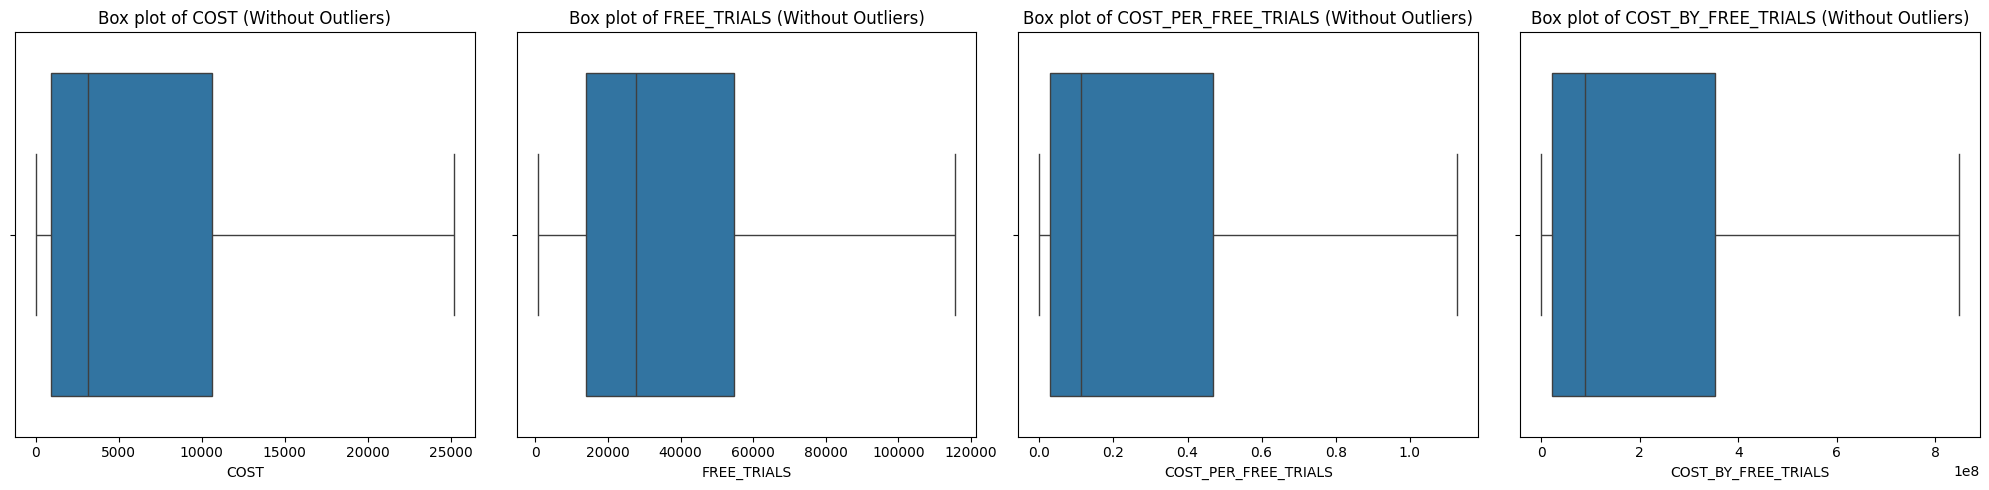

In [396]:
'''
Single Variation Continuous Analysis using BoxPlots:

1. A lot of outliers are visible in all visuals. The fact that we have a lot of points clustered around the upper whisker thinks there
is a reason behind such concentration of data points for cost and free trials .
2. COST/FREE TRIALS are generally on the lower end. We don't see a lot of campaigns being exorbitantly expensive or generating a lot of free trials.
    a. Campaigns generally cost $5,000-$10,000
    b. campaings genearlly generate 20,000-40,000 free trials
3. COST_PER_FREE_TRIALS is commonly low for most campaigns which aligns with the low cost and free trial. This is a good sign. However, the
outliers for COST_PER_FREE_TRIALS are areas of opportunities to revise their campaign strategy and reduce their cost for a better efficency score.
4. What separates the genearl pack to companies that are spending exorbitant amount on campaaigns? What are they doing differently? Why?

=> Action Items:
    a. Create low, medium, high spenders as binning categories for COST.
# '''


num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Plot each quantitative column
for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

# Repeat for boxplots without outliers
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten() if nrows * ncols > 1 else [axes]

for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, showfliers=False, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col} (Without Outliers)')
    axes[i].set_xlabel(col)


plt.tight_layout()
plt.show()

In [402]:
np.exp(10)-1

22025.465794806718

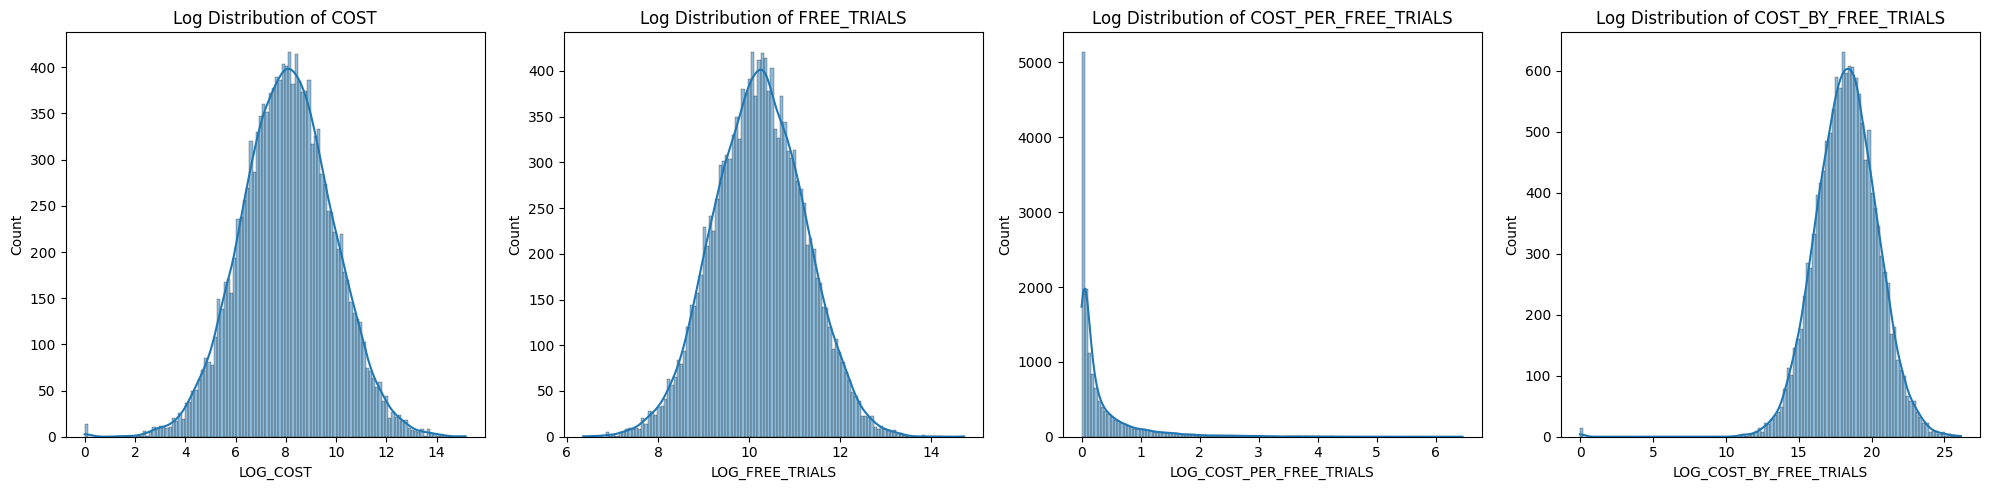

In [387]:
'''
Single Variation Continuous Log Analysis using Histogram with 118 bins | bin size ~= SqRoot(n):

1. The log transformation has normalized the data and reduced the impact of outliers. The distribution is now more symmetrical.
2. Cost Data: 68% of all campaigns to fall within one standard deviation of this range $402 -$22,025; the mean/median is $3,000.
3. Free Trials: 68% of all campaigns to fall within one standard deviation of this range 3,000 - 160,000; the mean/median is 22,000.
4. Free Trials has a broader distribution of values than Cost, which validates visuals seen already.
5. The log transformation on COST_PER_FREE_TRIALS did not yield the same results. We see a concentration of data around 0 which could
be driven by outliers which are still available. Also, since most campigns are on the lower end that means good return.

'''

num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot histograms for log-transformed variables
for i, quant_col in enumerate(quantitative):
    log_transformed = np.log1p(df[quant_col])  # Log-transform
    df[f'LOG_{quant_col}'] = log_transformed  # Add to dataframe
    sns.histplot(log_transformed, kde=True, bins=118, ax=axes[i])
    axes[i].set_title(f'Log Distribution of {quant_col}')
    axes[i].set_xlabel(f'LOG_{quant_col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


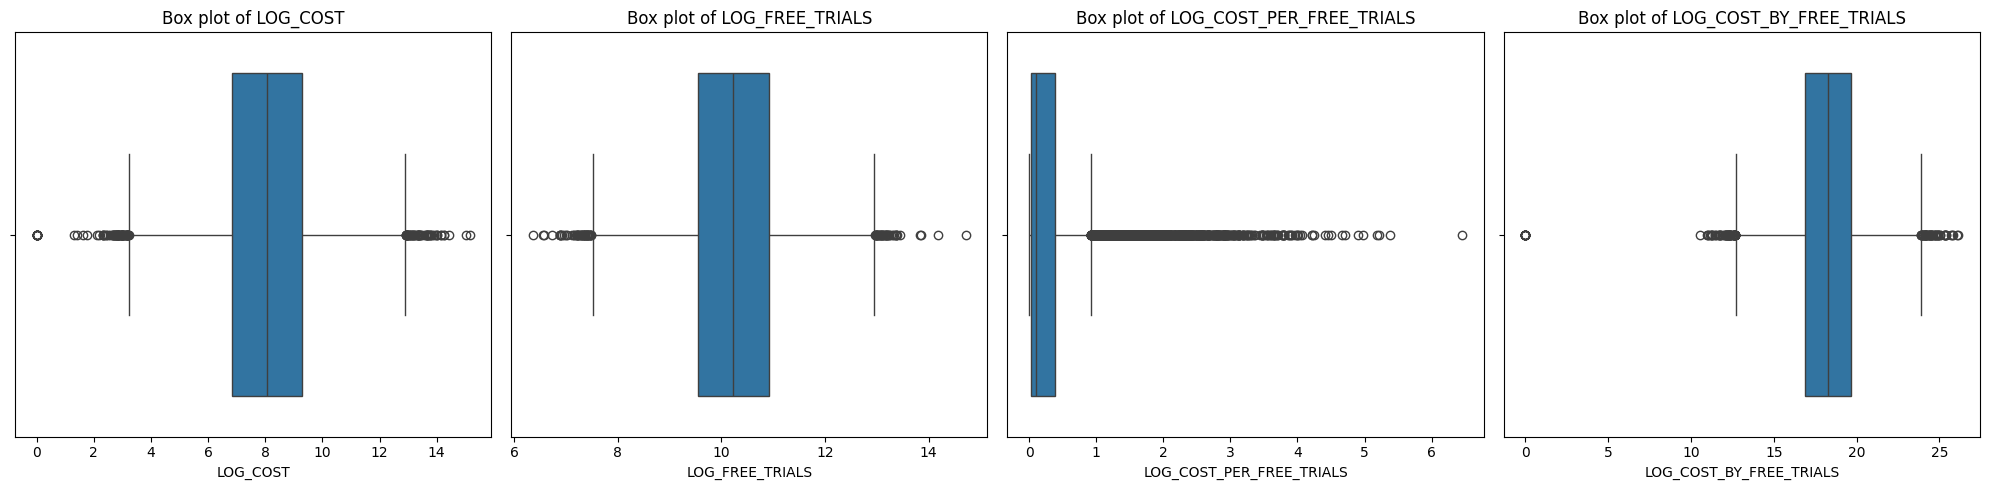

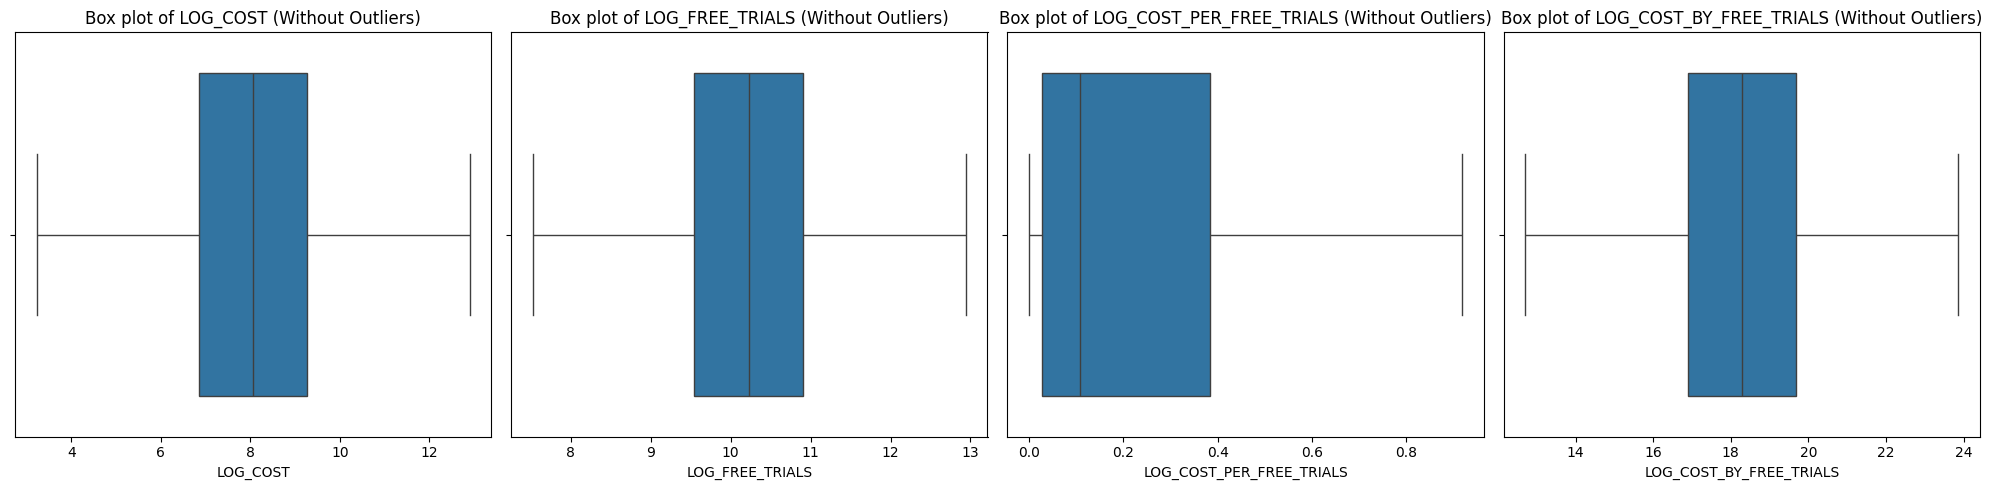

,COST,FREE_TRIALS,COST_PER_FREE_TRIALS,COST_BY_FREE_TRIALS
count,1.410800e+04,1.410800e+04,14108.000000,1.410800e+04
mean,1.655741e+04,4.545834e+04,0.964311,7.898312e+08
std,7.359892e+04,6.040529e+04,7.217306,4.949440e+09
min,0.000000e+00,5.762400e+02,0.000000,0.000000e+00
25%,9.457675e+02,1.393528e+04,0.028652,2.165098e+07
50%,3.164070e+03,2.777694e+04,0.113137,8.822948e+07
75%,1.064149e+04,5.467904e+04,0.469016,3.538239e+08
max,3.798940e+06,2.463082e+06,634.101017,2.245760e+11


In [409]:
'''
Single Variation Continuous Log Analysis using Box Plot for Log-Transformed

1. All visuals shows outliers on both tails except for LOG_COST_PER_TRIALS. LOG_COST shows symmetrical distribution with outliers on both tails.
Left tail might not offer much savings opportunities, but the right tail might provide opportunities to reduce expenses or look into a more cost
savings campaign strategy. Meanwhile, LOG_FREE_TRIALS has more outliers occuring on the lower tail than on the higher tail. Extrememe tail outliers
for COST can represent clusters of customers/companies where the non outliers are the third cluster.
2. LOG_COST_PER_TRIALS has less variance than the other log-transformed variables. This could be due to the fact many comapnies adopt similar
startegies/themes regarding stricving for efficent cost per free trial. However, we do have a bucnh of exterme outliers that are inefficent. This
could liely be either misallocation of resources/stategy, or these companies can afford to spend more on campaigns.
3. The fact that there are so many present outliers on oppsoite whiskers for most visuals makes me think these are more than just outliers and
instead suggests distinct business segments/behavioral clusters

=> Action Items:
1. Perform Cluster Analysi, and segmentation/binning(3groups; low whisker, high wisker, and 98% relvancy) on COST, to identify if new unlabeled data
match with tierd cost spendings.
2. For each cluster/cost segmentation, create additional KPI metrics aligning to clusters and segments only.
3. Create Covariation Analysis with 'LOG_COST' and 'LOG_FREE TRIALS' using a scatterplot. - DONE
4. Inspect outliers and extreme outliers from log transformation  and slice the data to see if they aretruly outliers. For extreme outliers
in 'FREE TRIALS', filter data on them and see cost value and general metadata to see if any patterns emerge. Vise Versa.
'''
num_cols = len(quantitative)
ncols = 4
nrows = (num_cols // ncols) + (num_cols % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

axes = axes.flatten()

for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col}')
    axes[i].set_xlabel(f'LOG_{col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, showfliers=False, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col} (Without Outliers)')
    axes[i].set_xlabel(f'LOG_{col}')


plt.tight_layout()
plt.show()

df[quantitative].describe()

### MultiVariate Analysis on Continuous Data

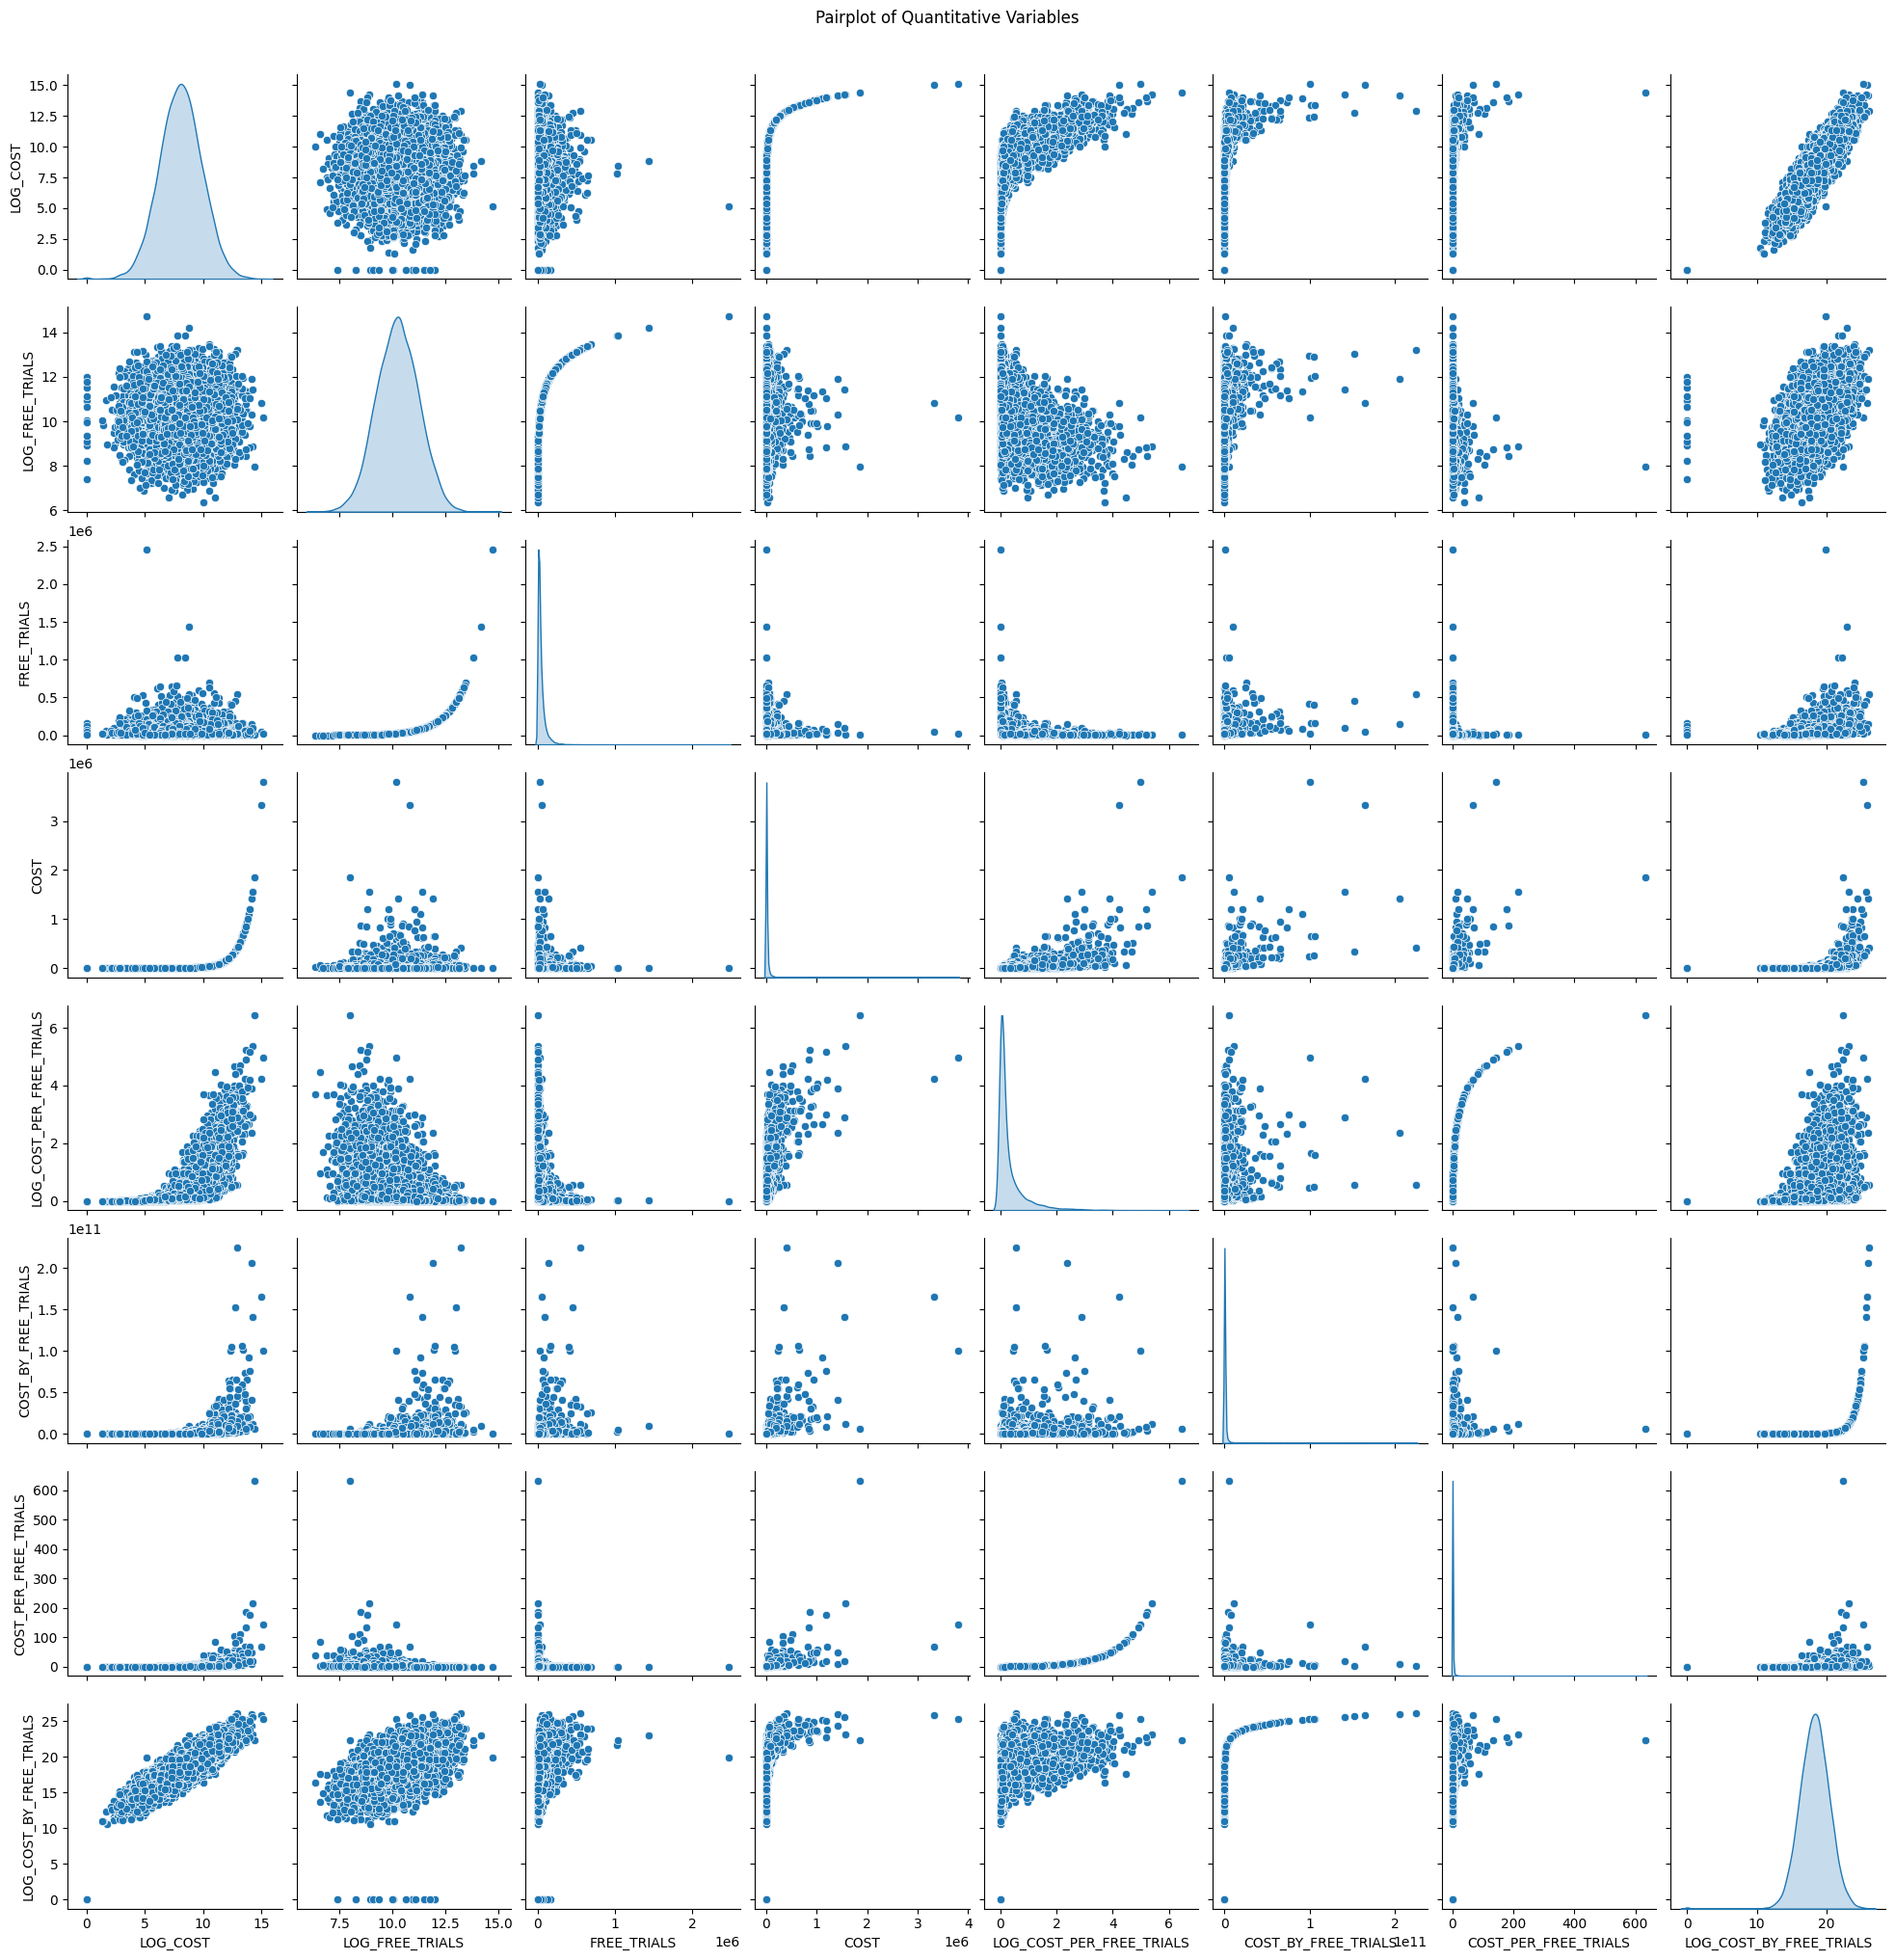

In [412]:
'''
Covariation Analysis using Scatterplot:

1. LOG_COST and LOG_FREE_TRIALS doesn't show a strong linear relationship. While we do see data where there is a positive relationship, we also see diminishing
returns and/or increase the likelihood of a campaign  not effectively generating a typical "linearly relationship" free trial count. We see a bunch of campaigns
that cost nearly nothing and yet generated a lot of free trials. This could be really efficent campaign strategy or incorrect data misrepresentation.
2. We see a a lot of non-linear relationships. We can either perform more feature enginering like square root or taking the polynomial or we can use a model to capture
relationships beyond linear. IE: LOG_COST and LOG_COST_PER_FREE_TRIALS. We see an inflection point which can be seen as a threshold showing LOG_COST_PER_FREE_TRIALS to increase.
This further strengthens our hypothesis that once you sepnd acertain amount you get dmiinishing returns.
3. No evidence of any visuls with any indication of any linear relationship.
4. For campaigns that require minimal cost, there's a wide  spread of LOG_COST_PER_FREE_TRIALS signalying high variability in efficiency at lower spending levels. This likely delinates
the comapnies that are succesfull in buidling their brand lyoalty and customer base and leveraging that to generate free trials at a efficeint clip (high efficeny)  while others might struggle and
might need to revise their campaign strategy (higher in y-axis). Also, increasing your cost you put in your campaigns can lead to  inefficent returns; the more you sepnd the more risk you
introduce.
5. LOG_FREE_TRIALS and LOG_COST_PER_FREE_TRIALS shows a negative relationship. This reinforces the behavior that as your cost/free trials becomes more efficent (loower metric) the likely chance
you will yield more free trials. This indicates a good strategy is important and it's not nearly about throwing additional money .

=>. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two.
    b. Filter data on 0's in 'LOG_COST' for more analysis.
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
'''
totalColumns = set(df.columns)
totalColumns.remove('REPORT_DATE')

quantitative=list(set(totalColumns) - set(categorical))
quantitative

#LOG_COST_PER_FREE_TRIALS	LOG_COST_BY_FREE_TRIALS
sns.pairplot(df[quantitative], diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Quantitative Variables', y=1.02)  # Title for the entire plot
plt.show()

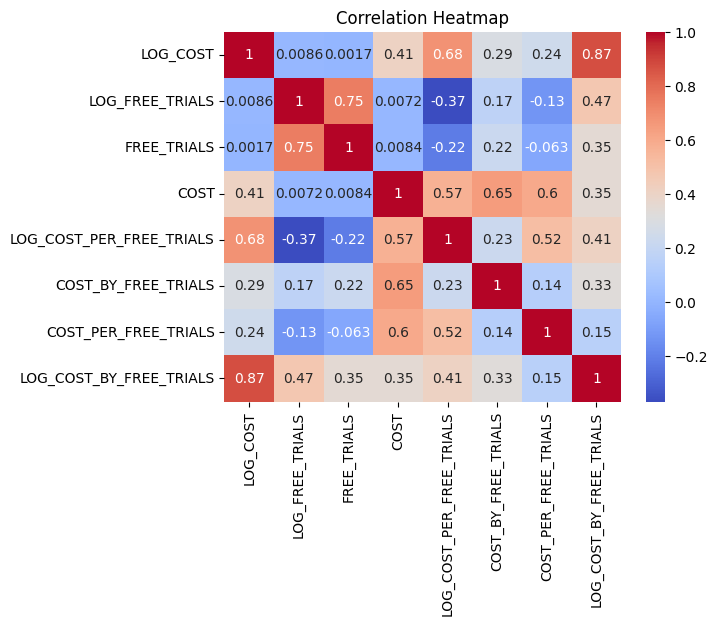

In [ ]:
'''
1. Most relationships show weak linaer relationships which is validated in the visual scatterplot.
2. Since we are predicting FREE_TRIALS, the heatmap indicates that using a linear model might not be the most effective model to use.
'''
sns.heatmap(df[quantitative].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Univariate Analysis on Categorical Data

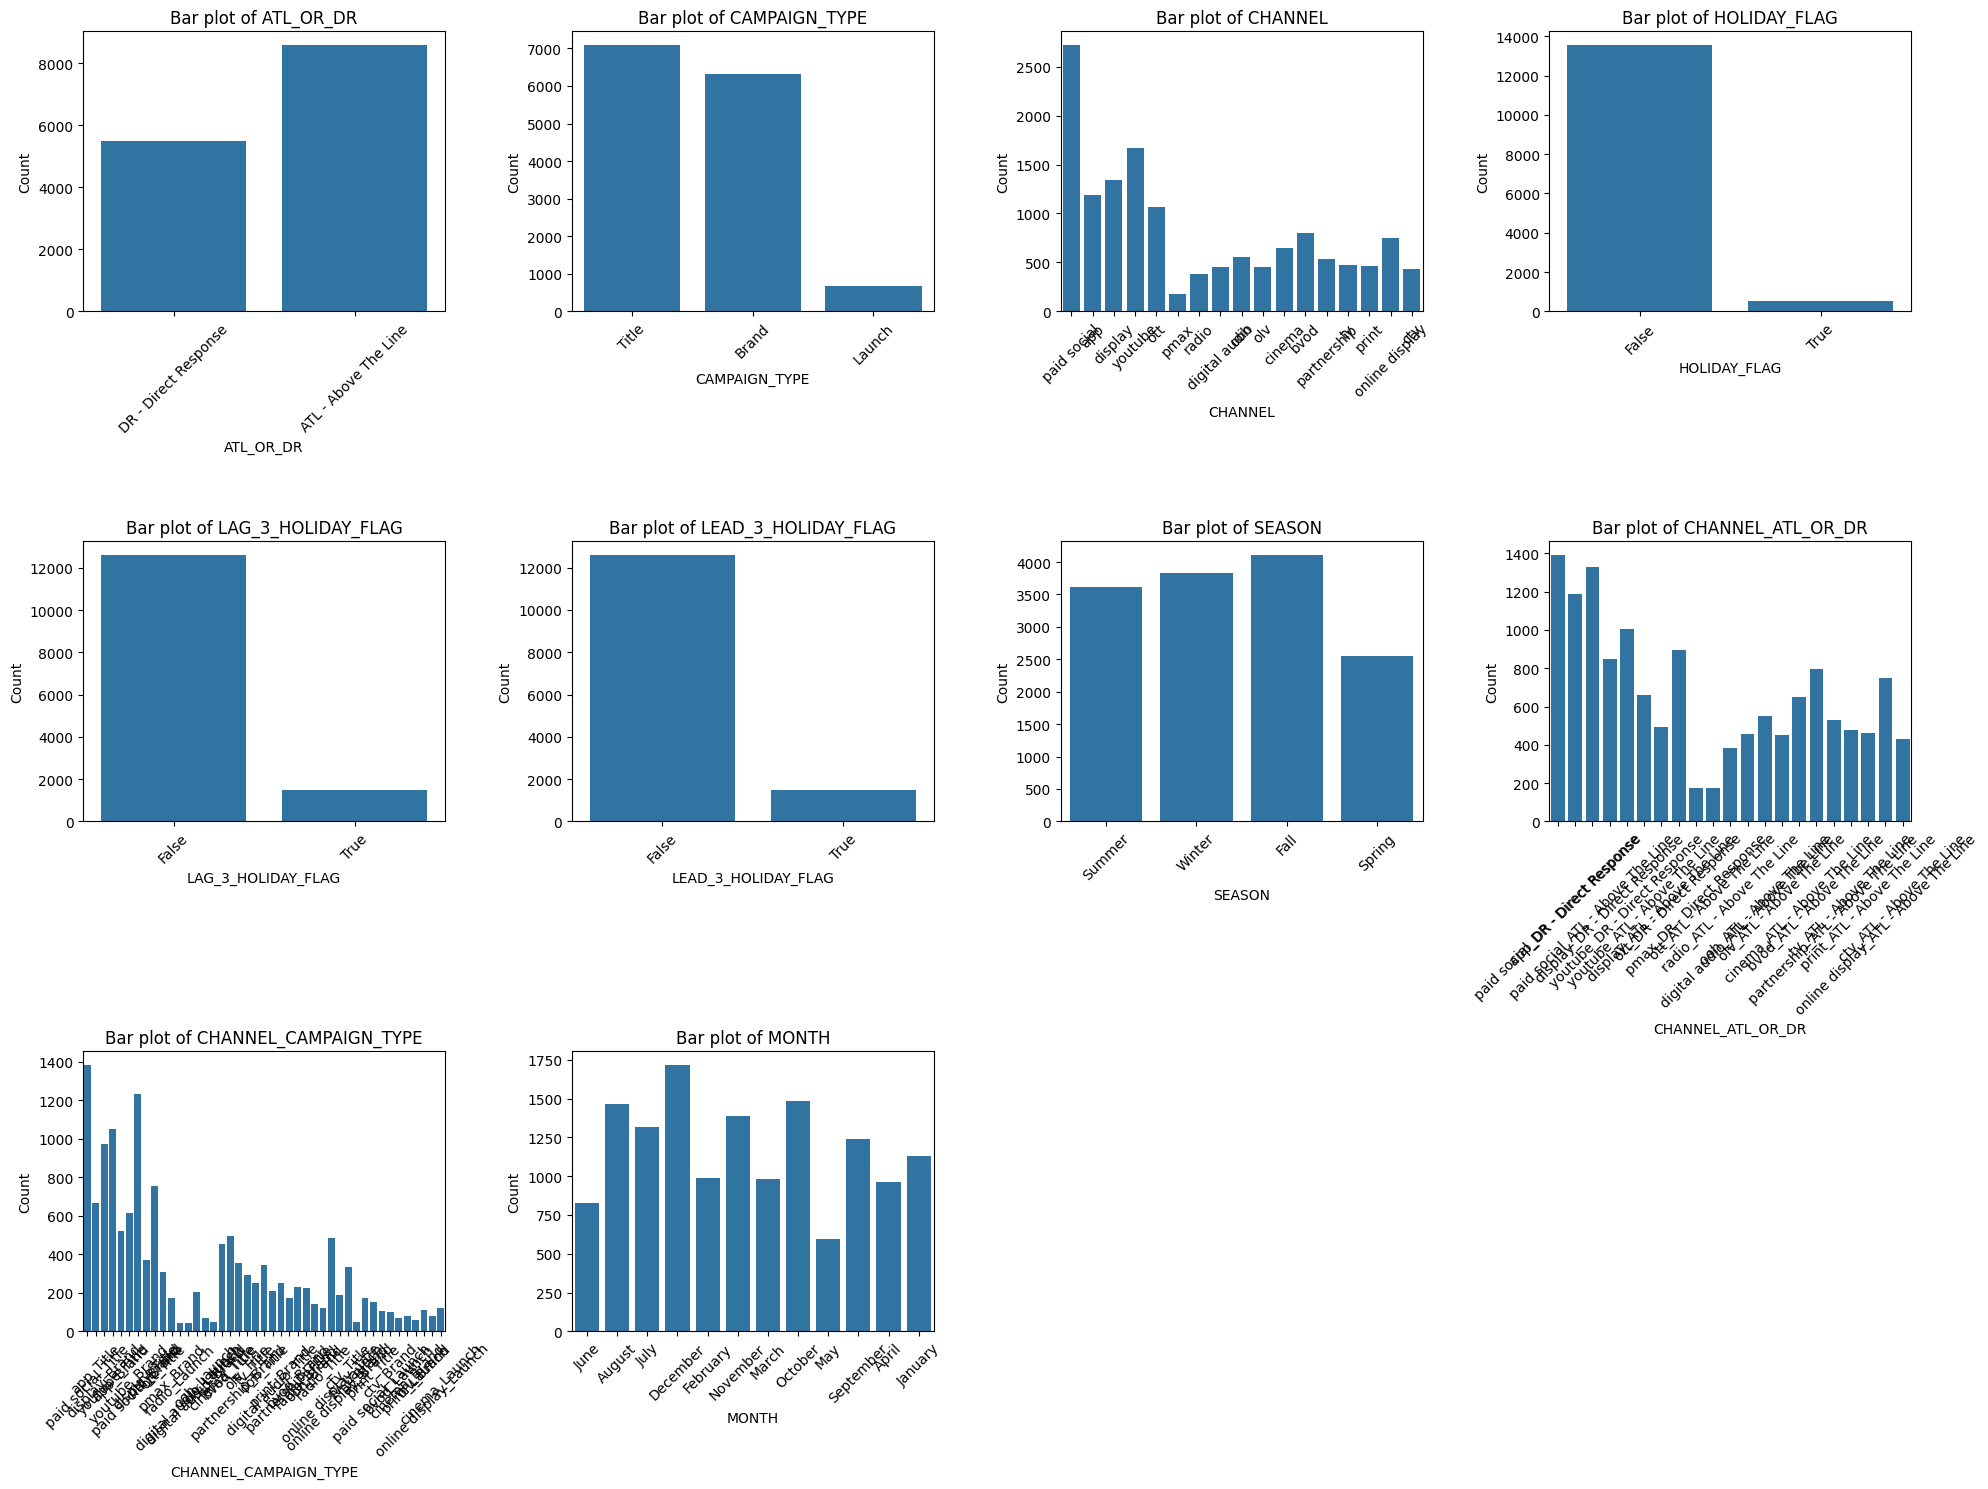

In [390]:
'''
Single Variation Categorical Analysis using Barchart:

1. 'ATL_OR_DR' Observations/Thoughts/Tasks:
    a. Most campaigns are ATL than DR. This aligns with your typical business case of consistently building and
    reinforcing your brand compared to direct response, which is tailored to specific usecases.
    b. I would assume DR generates a lot of free trials since it is immediate and digital, but might not be as affective
    in regards to customer retention. (More data would be needed) However, while sometimes ineffective, it's cheaper.
    This could be a useful strategy and/or pilot to test out certain markets/customer segments behaviors.
    c. I would assume ATL has a higher cost variance than DR since ATL heavily depends on targeting a broader reach and
    having a longer airtime since you are consistenly trying to build and reienforce your brand. But these can vary from
    media types/devices hence the high variance. Special holidays/events can also drive up costs. Free trials tend to be
    smaller but you will have outliers like special events/holidays.

2. 'CAMPAIGN_TYPE' Observations/Thoughts/Tasks:
    a. There are no Promotional Campaigns.
    b. Brand and Title campaigns dominate, while Launch campaigns are infrequent. This aligns with typical product
    lifecycle, where certaint market/regions can have saturiation and therefore have higher barriers of entry leading to
    infrequent new launches/relaunches while companies continue to build and reinforce their brand.
    c. I would assume Brand/Title campaigns may have higher costs than Launch since Brand/Title has to reach a larger
    audience and reach. Brand/Title is more associated with ATL and Launch is more assoicated with DR.

3. 'CHANNEL' Observations/Thoughts/Tasks:
    a. Social and YouTube, which makes sense in the iOT world, drive the makeup of channel for where campaigns get aired.
    Meanwhile, Tv, radio,and print are on the lower tier which illustrastes the shift in digital age. Seeing the cost
    associated to 'CHANNEL' types would help us understand the trade-offs of reallocating resources and areas of
    opportunity.
    b. While Social and YouTube dominate, simply reallocating resources from low-performing channels (e.g., Radio)
    to top channels may not be ideal. Customer segments from different channels could vary significantly and can lose out
    on niche segments. Cost Benefit Analysis would be needed to understand the trade-offs of reallocating resources.

4. Action Items:
    a. Covariation Analysis between Categorical & Continuous' using Scatterplot and hue
    b. Covariation Analysis between categorical and continuous using boxplot and barcharts
'''
num_cols = len(categorical)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot bar plots for each categorical variable
for i, cat in enumerate(categorical):
    sns.countplot(x=cat, data=df, ax=axes[i])
    axes[i].set_title(f'Bar plot of {cat}')
    axes[i].set_xlabel(cat)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Multivariate Analysis

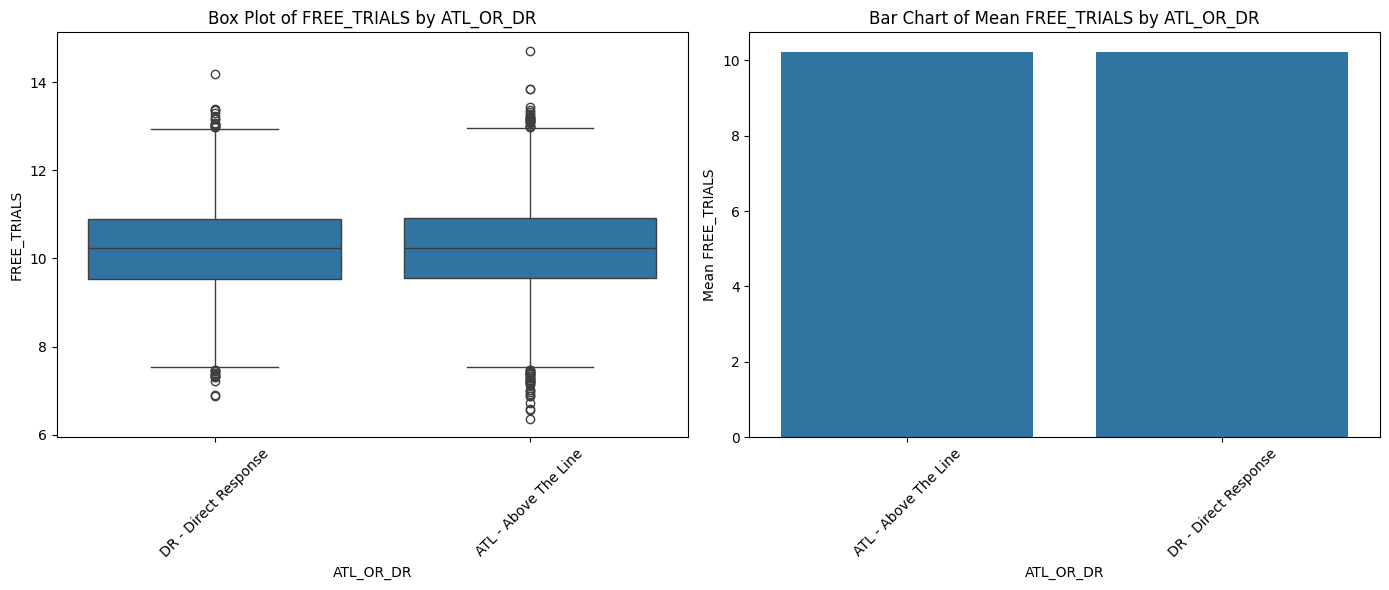

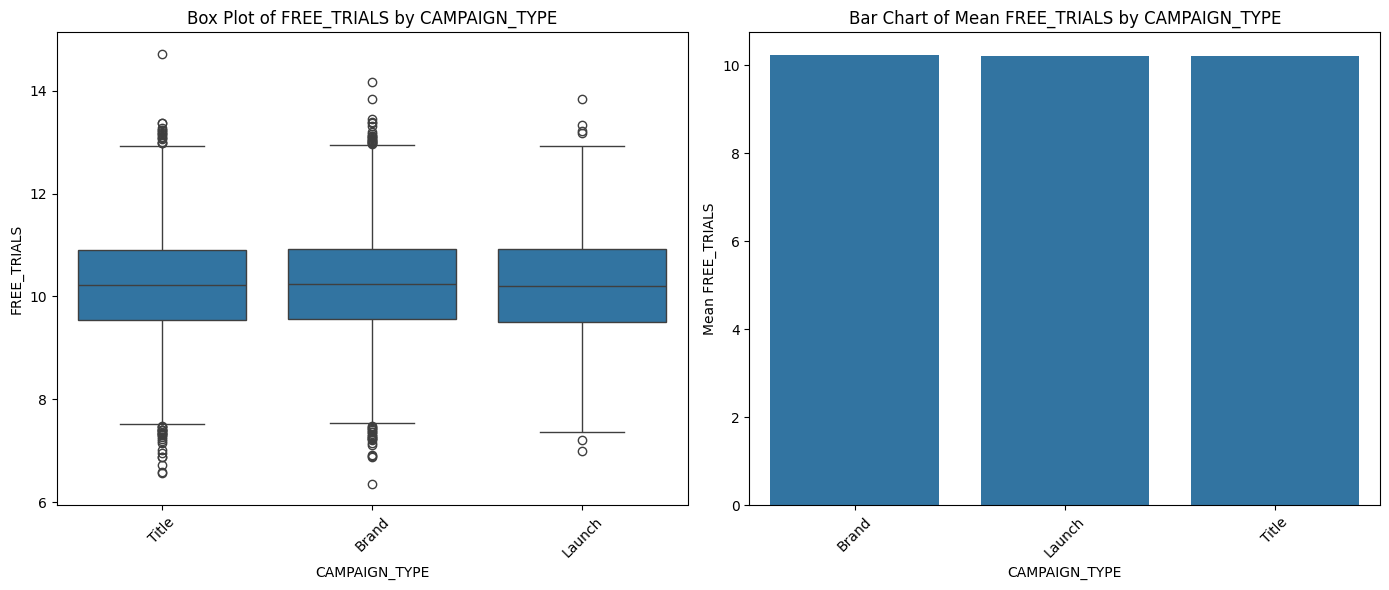

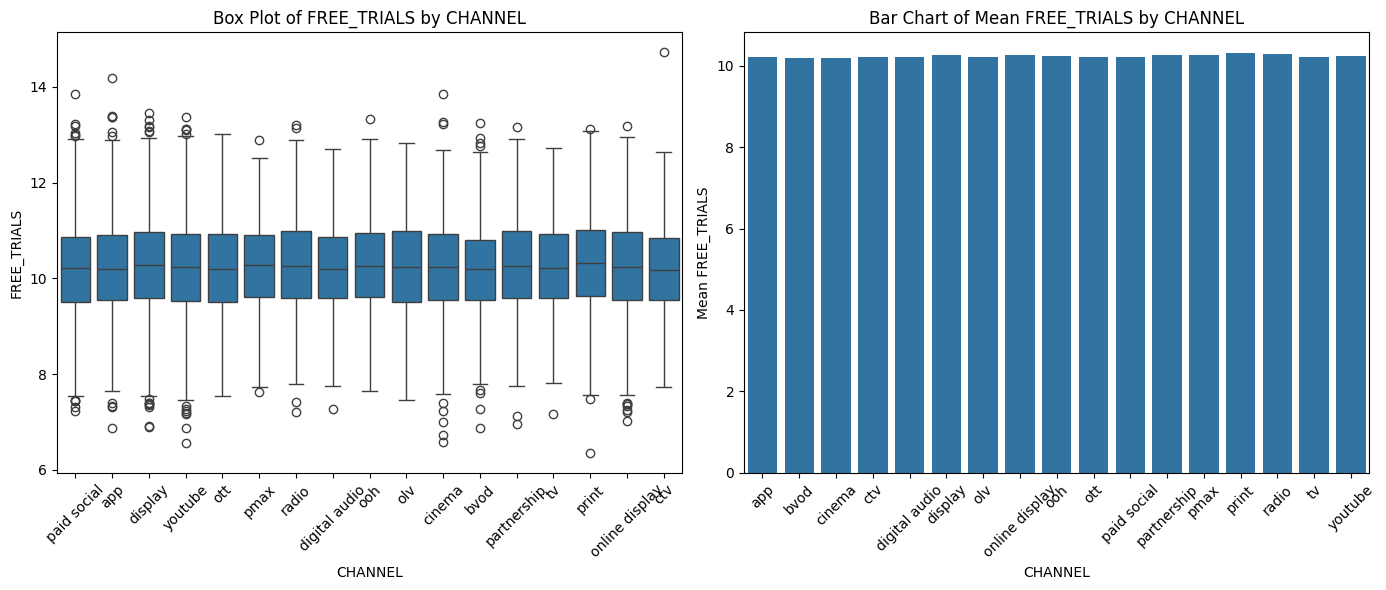

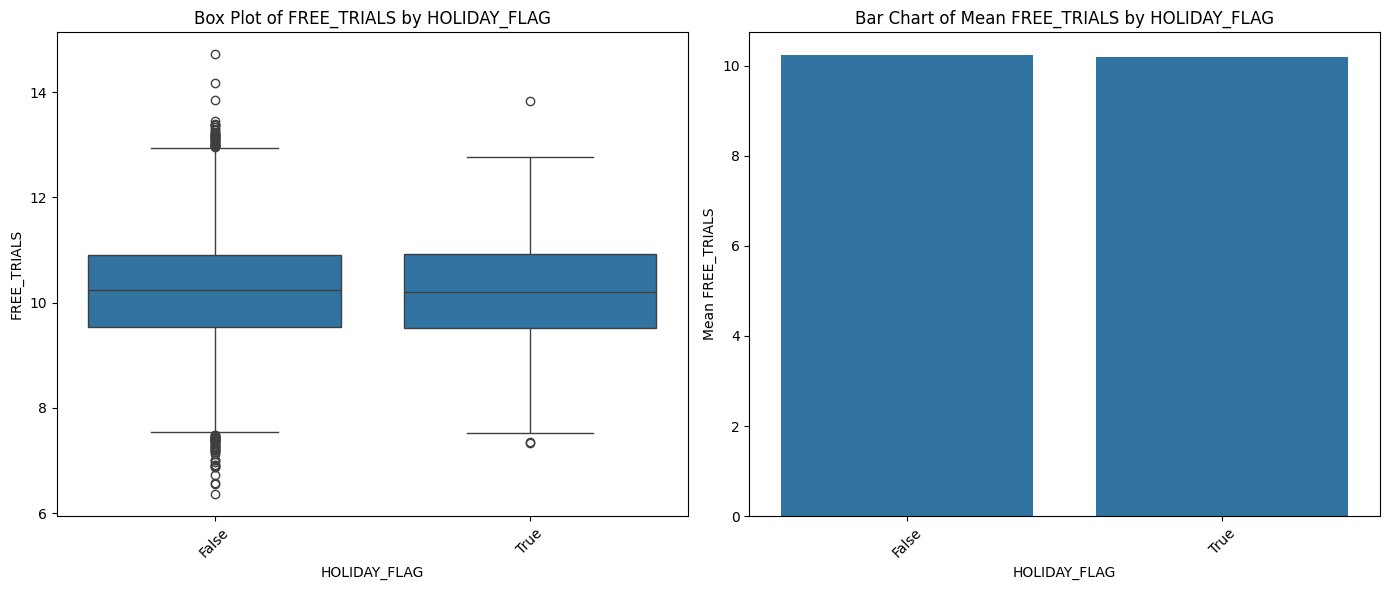

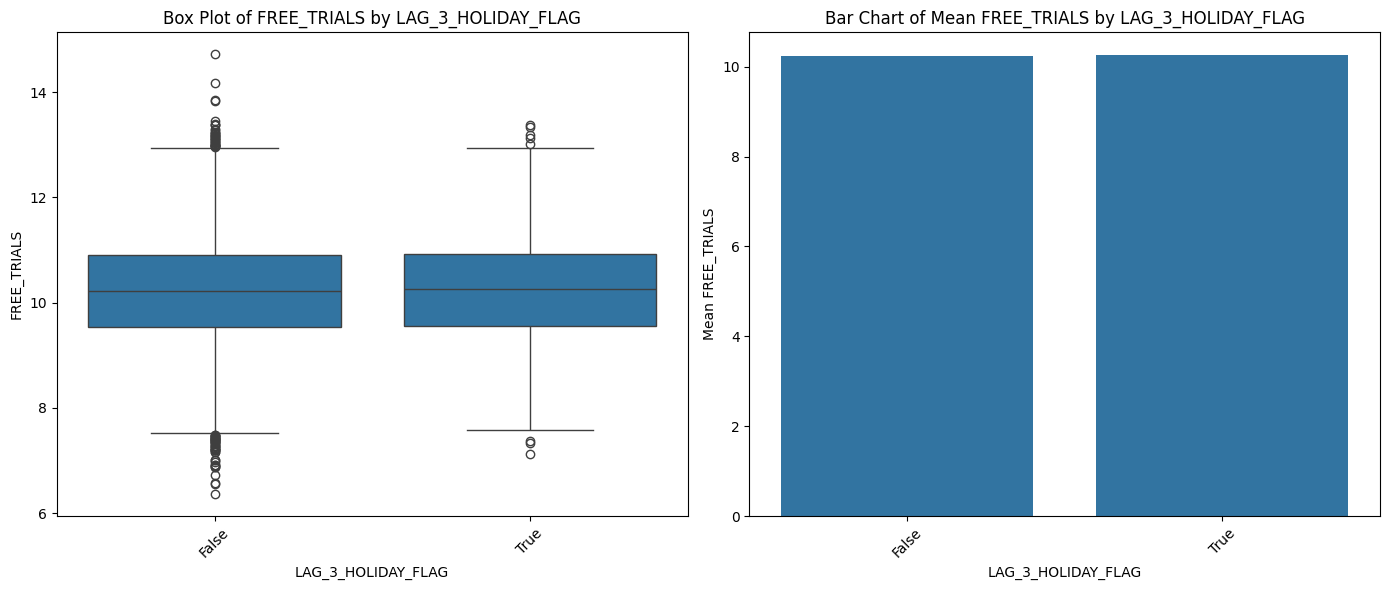

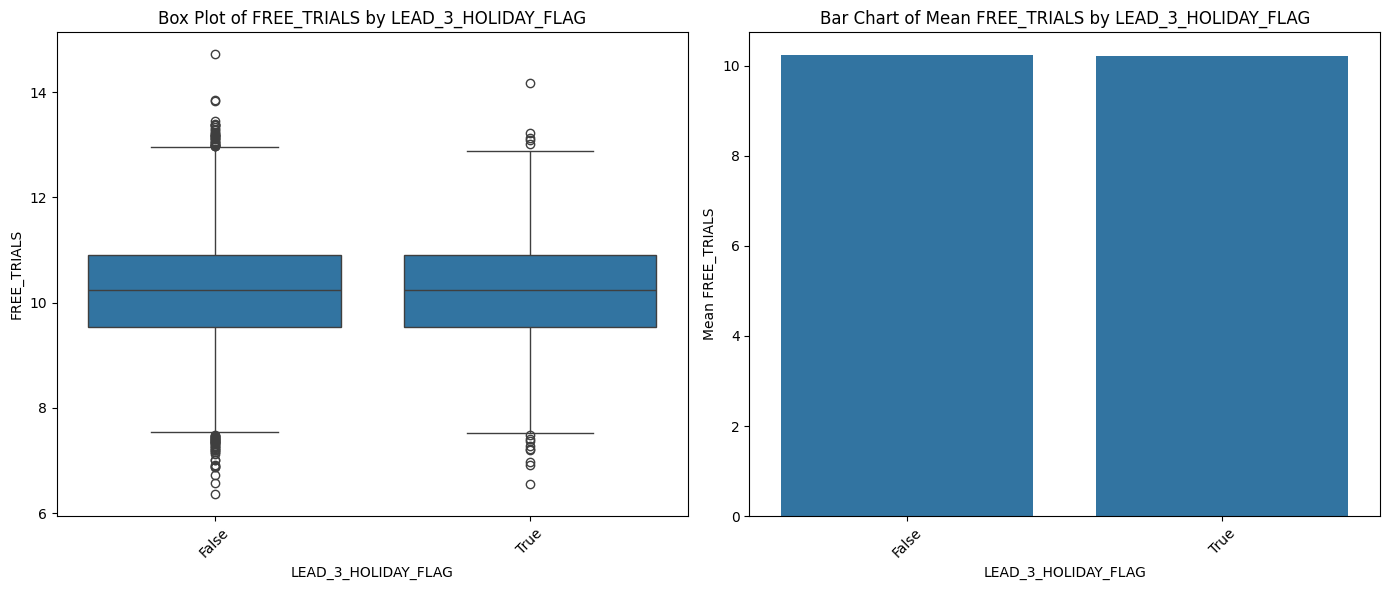

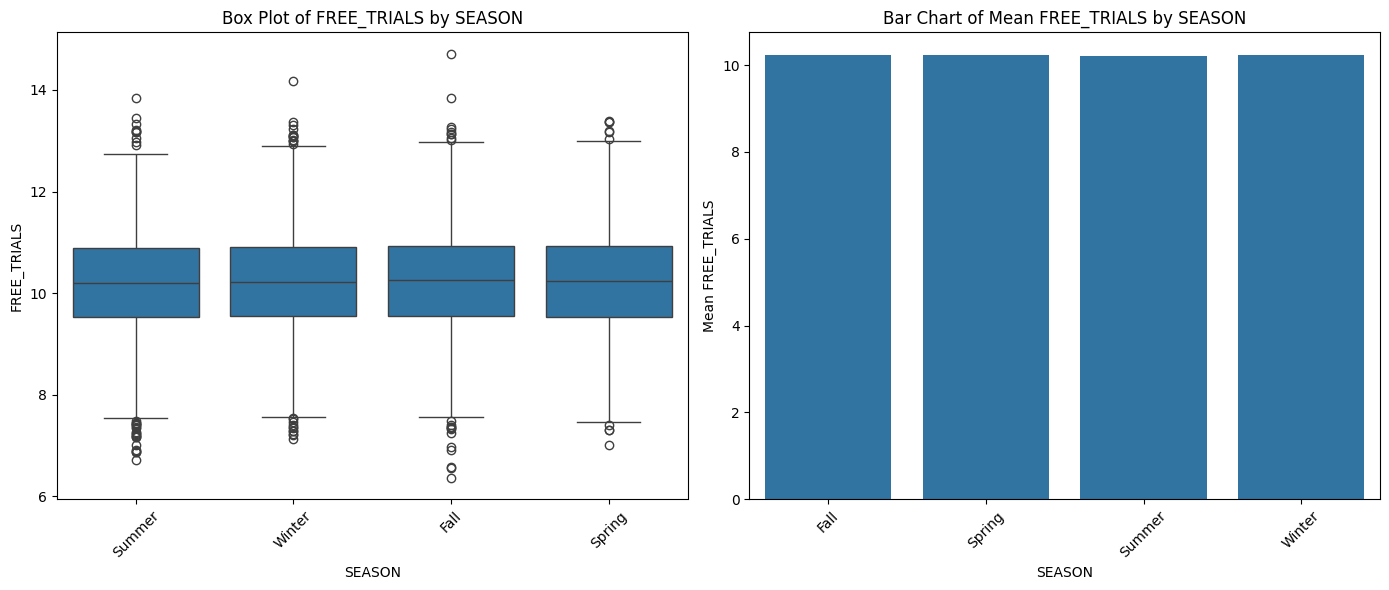

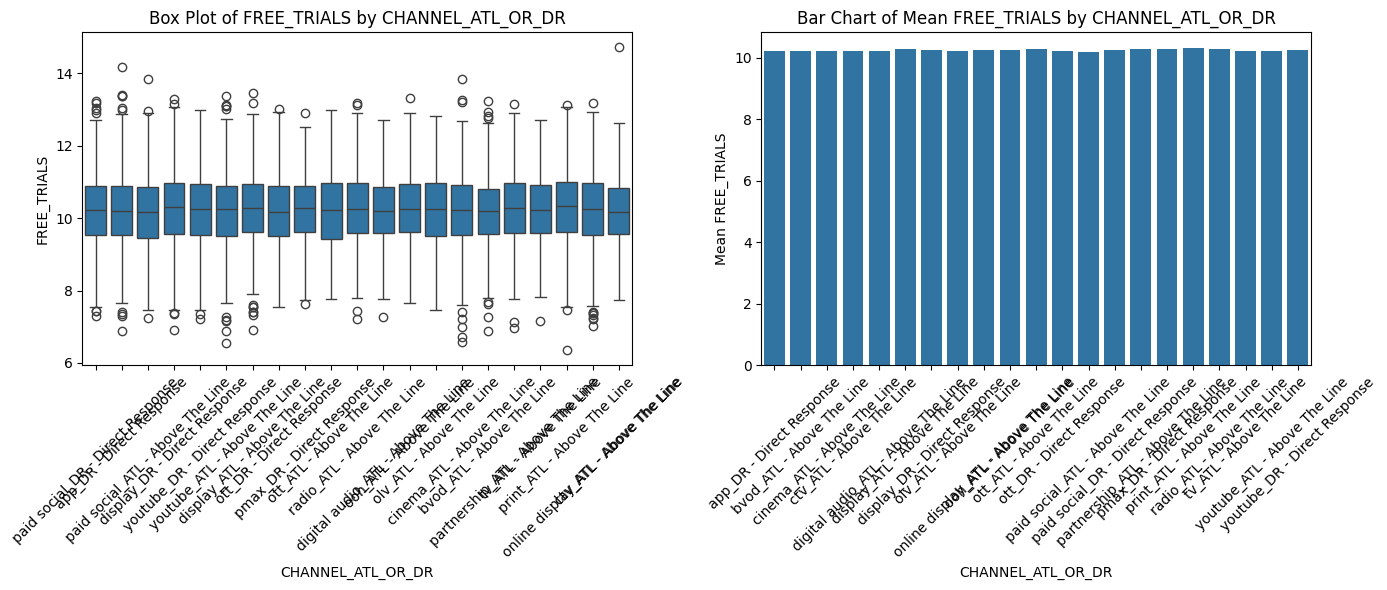

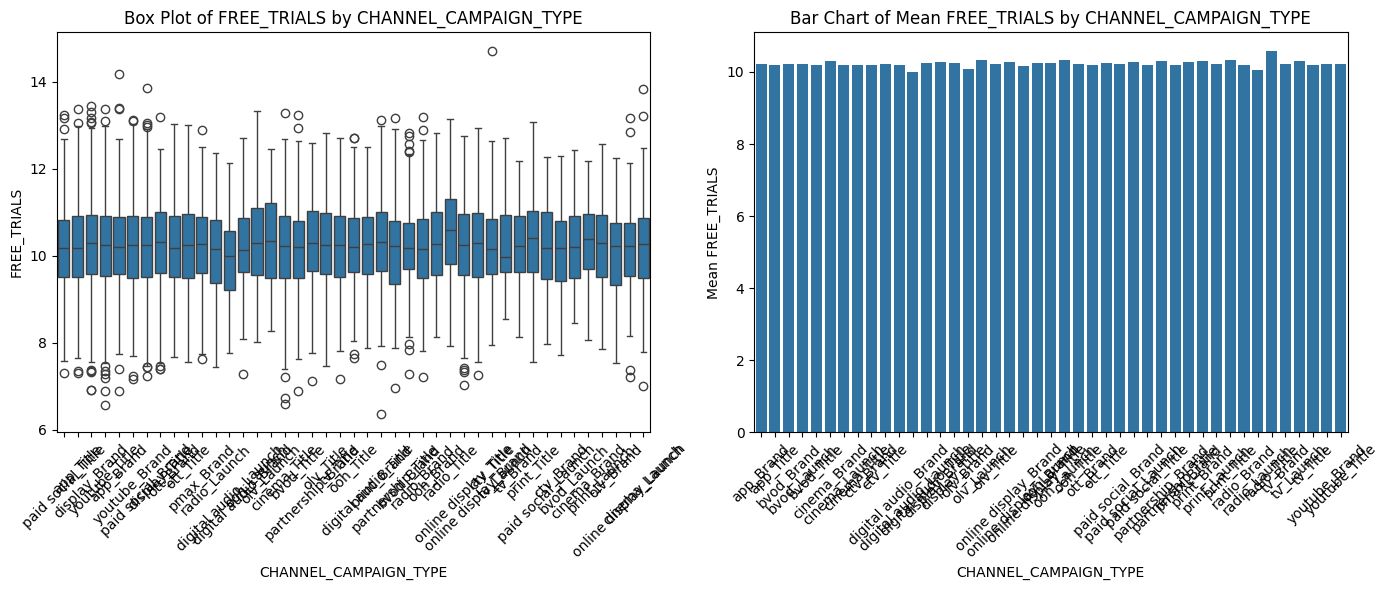

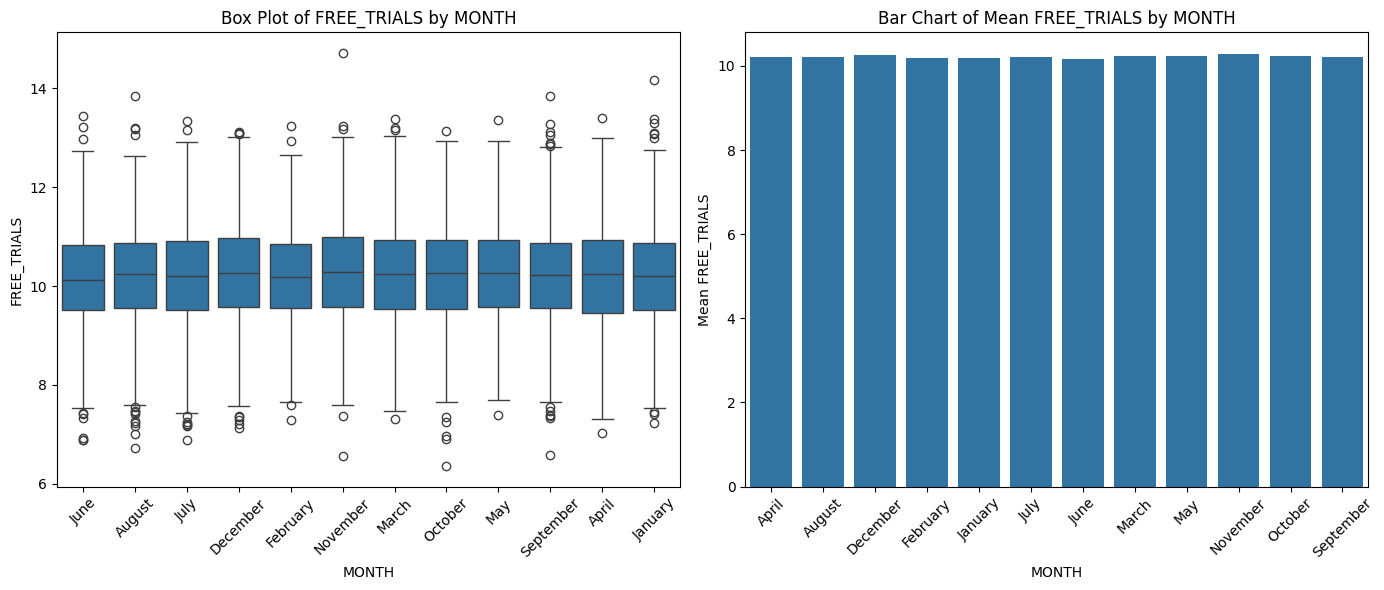

In [353]:
for category in categorical:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='LOG_FREE_TRIALS', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of FREE_TRIALS by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('FREE_TRIALS')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart
    bar_data = df.groupby(category)['LOG_FREE_TRIALS'].mean().reset_index()
    sns.barplot(x=category, y='LOG_FREE_TRIALS', data=bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean FREE_TRIALS by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean FREE_TRIALS')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()

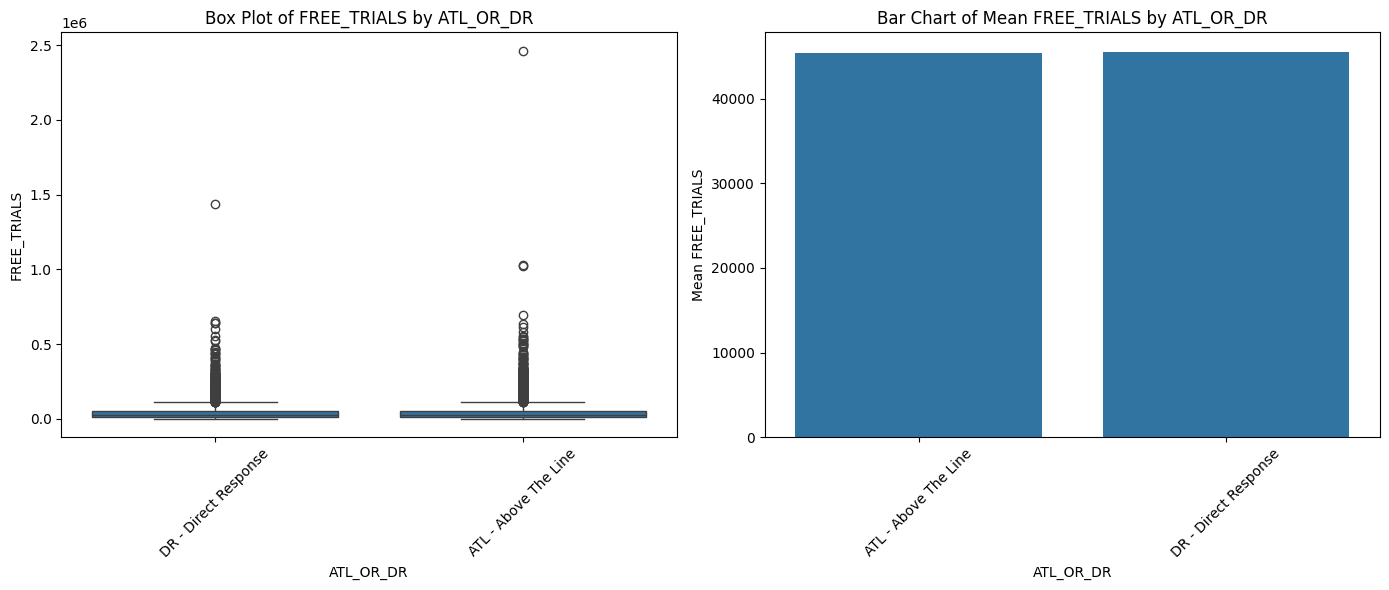

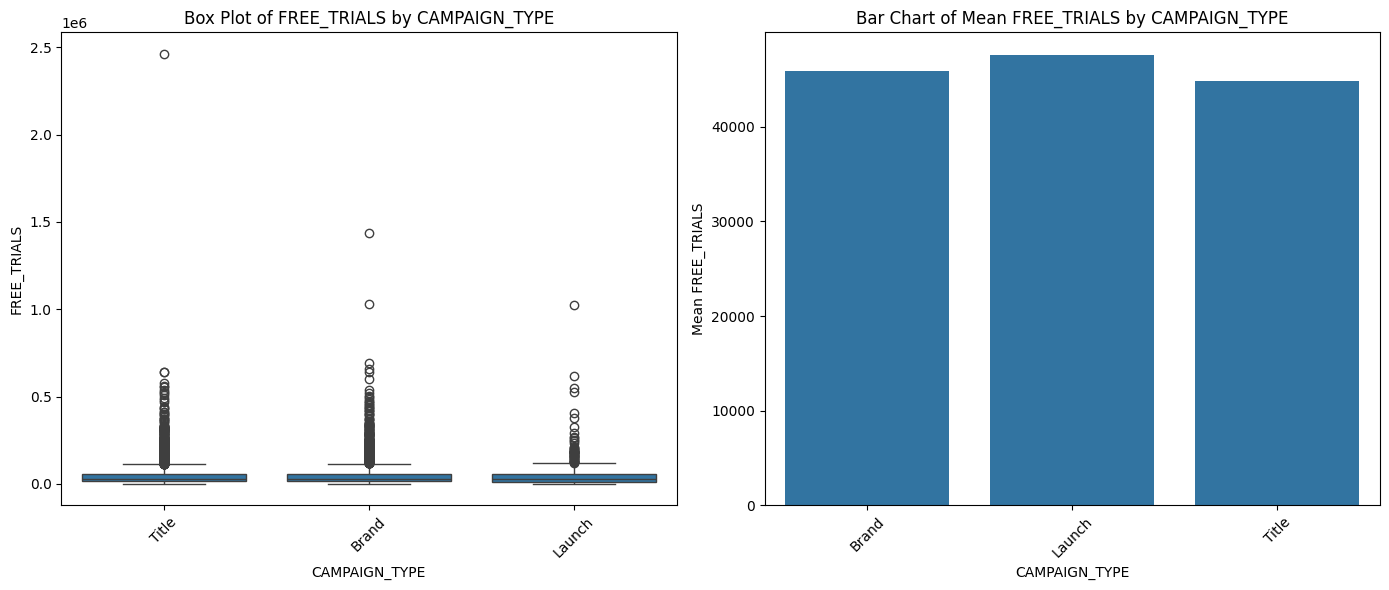

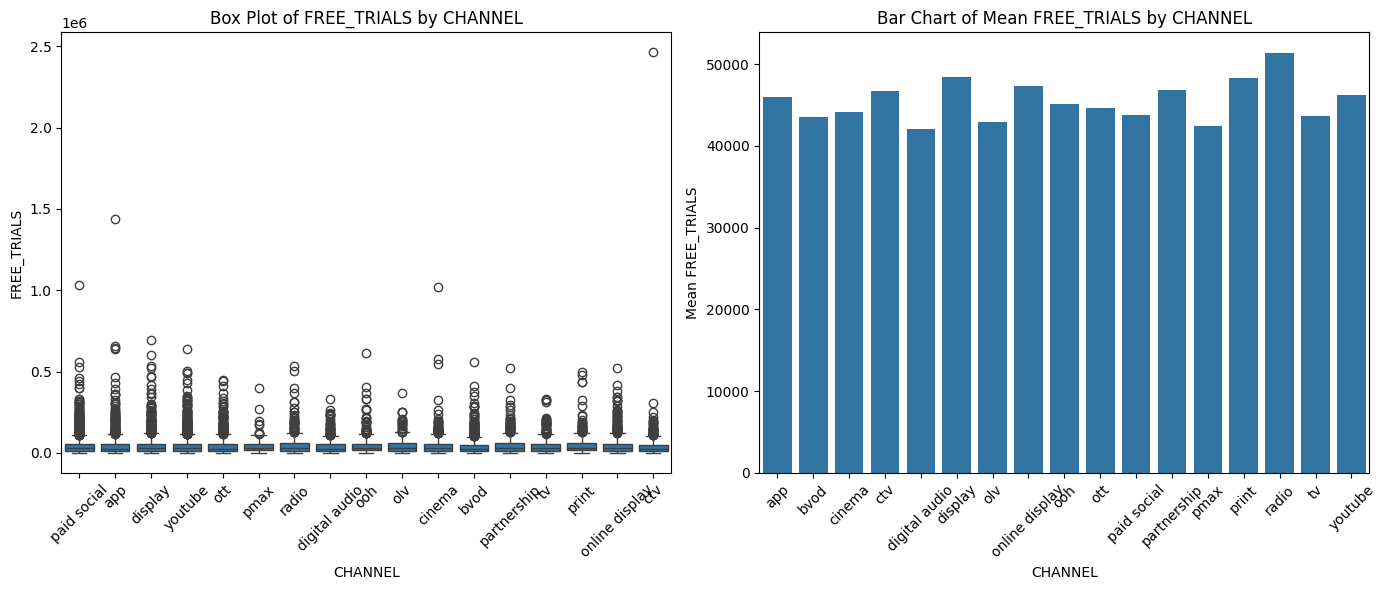

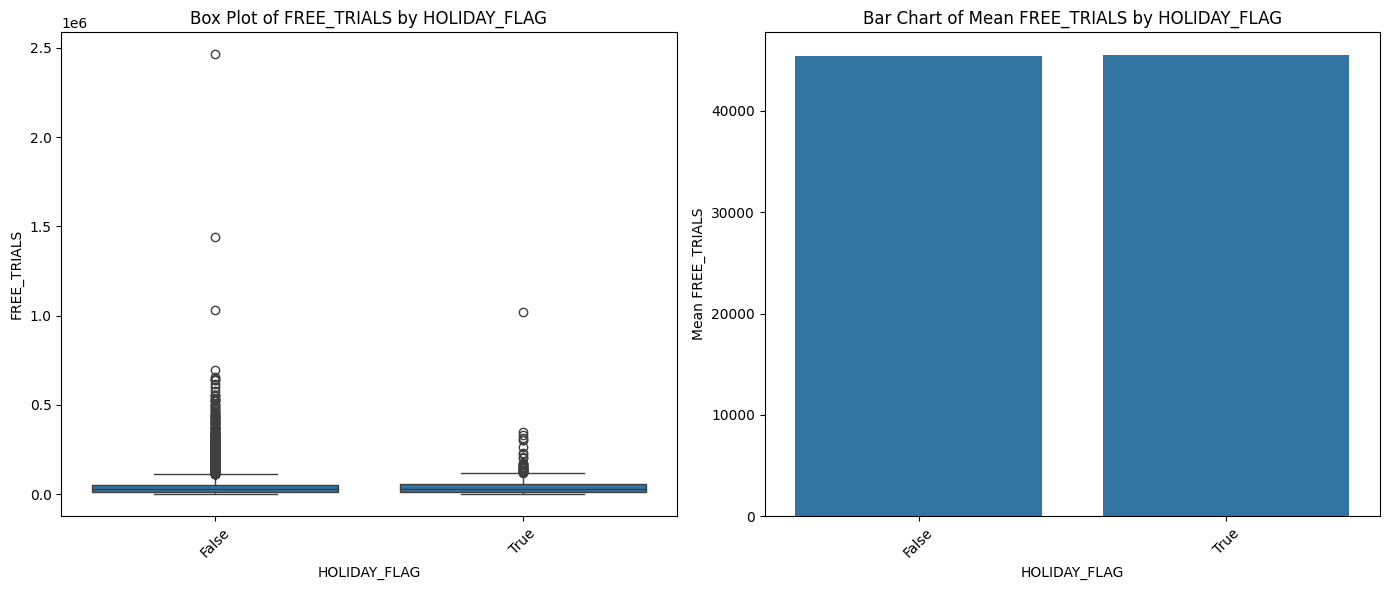

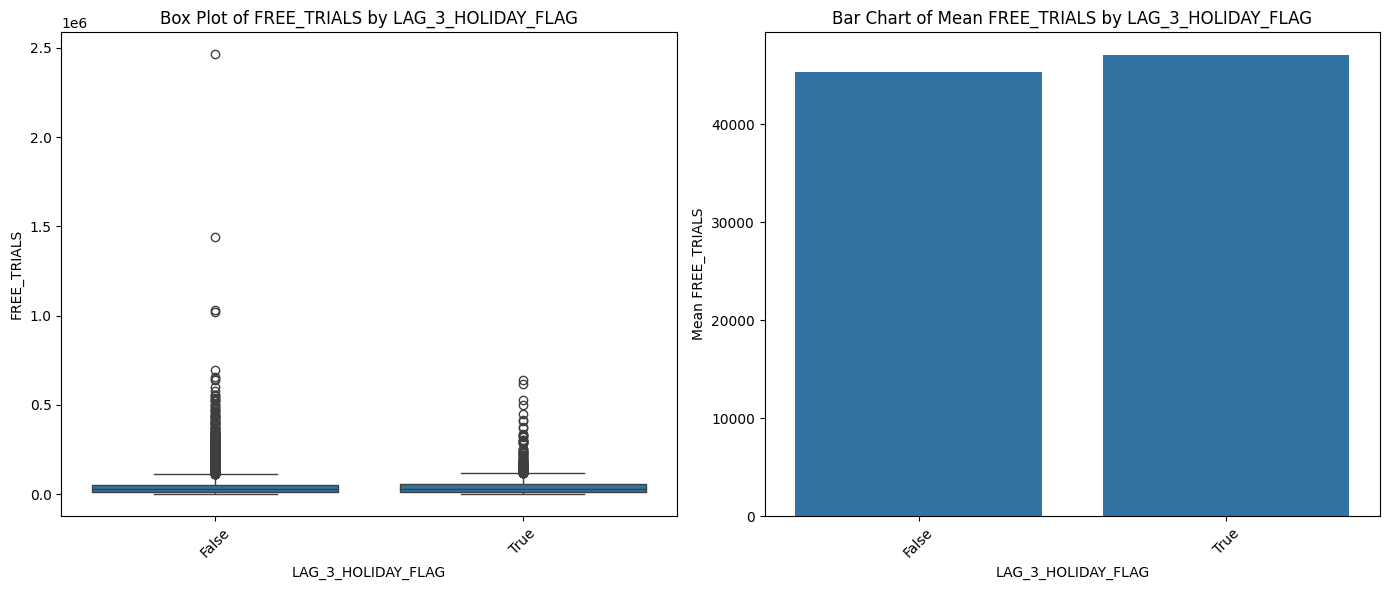

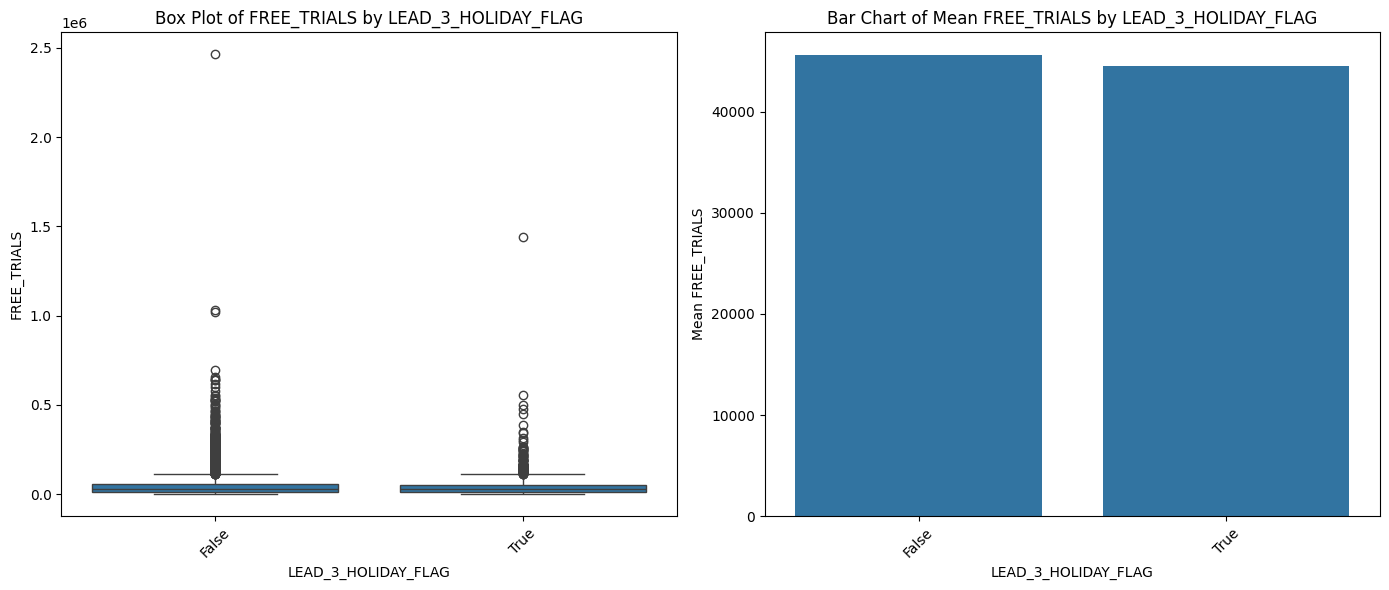

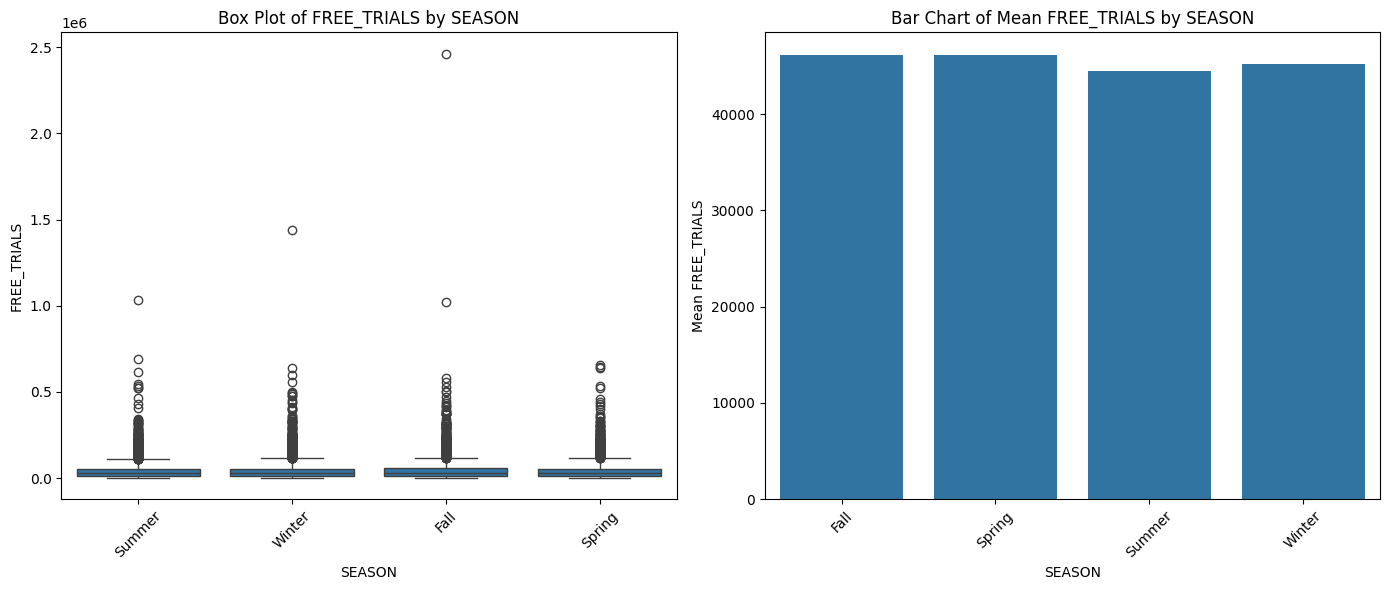

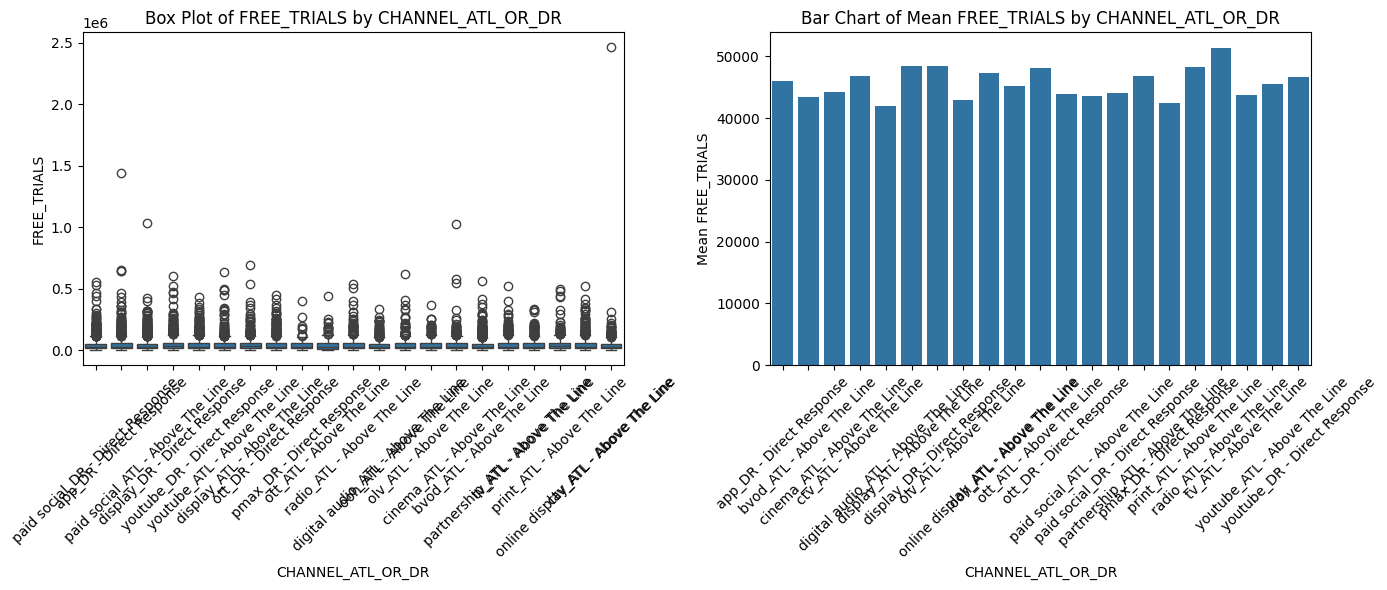

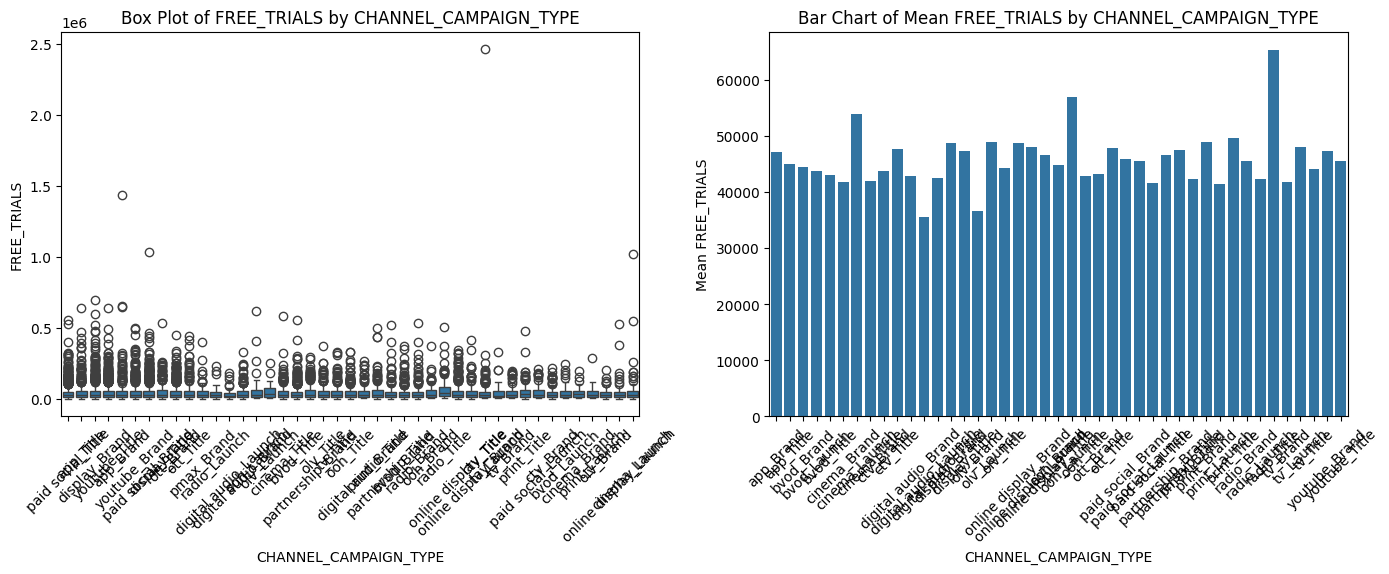

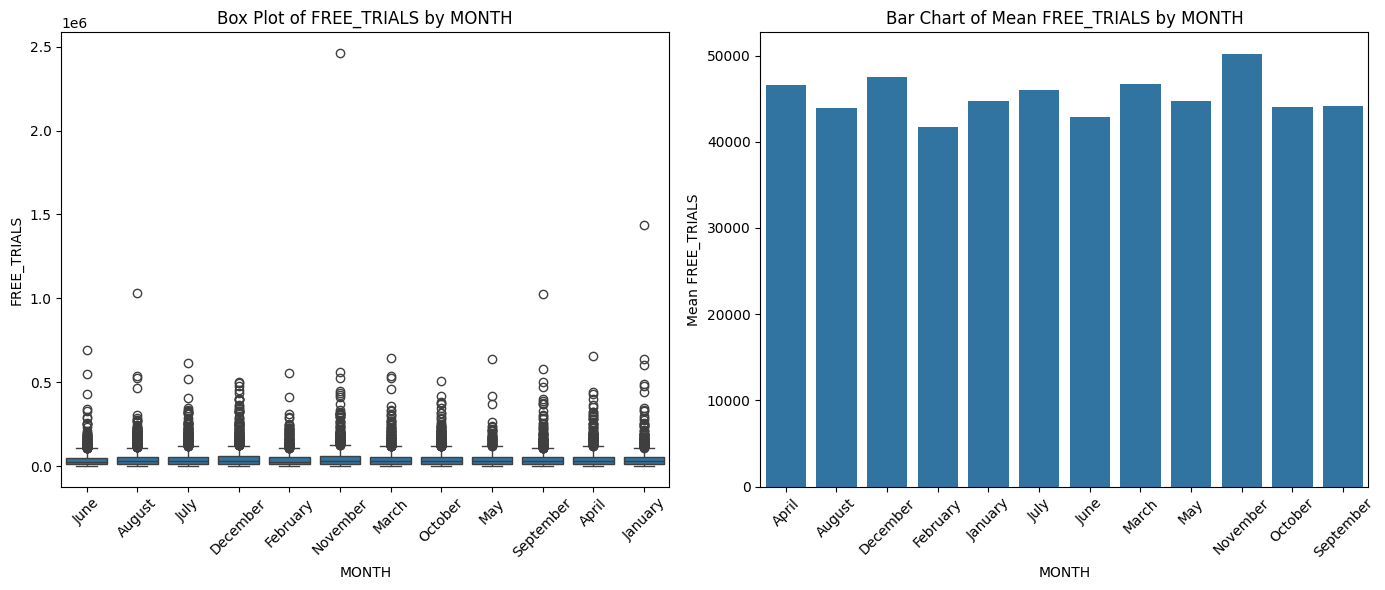

In [357]:
for category in categorical:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='FREE_TRIALS', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of FREE_TRIALS by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('FREE_TRIALS')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart
    bar_data = df.groupby(category)['FREE_TRIALS'].mean().reset_index()
    sns.barplot(x=category, y='FREE_TRIALS', data=bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean FREE_TRIALS by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean FREE_TRIALS')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [354]:
# '''
# 1. General Observations/Thoughts/Tasks:
#     a. ATL is more spread out on the 'FREE TRIALS' and 'LOG_COST'. This can indicate the various cost sturctures and
#     channel types options (15 vs. 6).
#     b.We see a positive relationship but as we increase our spending cost, the more exposed we are to having more liklihood to get diminishing returns in free trials being generated.
# '''
# # for cat in categorical:
# #     plt.figure(figsize=(7, 5))
# #     sns.scatterplot(
# #         x='COST_log', y='FREE TRIALS_log', hue=cat, data=df, alpha=0.7, palette='viridis'
# #     )
# #     plt.title(f'Scatter Plot of COST vs. FREE TRIALS by {cat}')
# #     plt.xlabel('Cost')
# #     plt.ylabel('Free Trials')
# #     plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt

# for cat in categorical:
#     sns.pairplot(
#         data=df,
#         vars=quantitative,
#         hue=cat,
#         diag_kind="kde",
#         height=2.5,
#         palette="Set2",
#     )
#     plt.suptitle(f'Pairplot of Quantitative Variables by {cat}', y=1.02)
#     plt.show()



In [355]:
df

,REPORT_DATE,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE_TRIALS,HOLIDAY_FLAG,LAG_3_HOLIDAY_FLAG,LEAD_3_HOLIDAY_FLAG,SEASON,MONTH,CHANNEL_ATL_OR_DR,CHANNEL_CAMPAIGN_TYPE,COST_PER_FREE_TRIALS,COST_BY_FREE_TRIALS,LOG_COST,LOG_FREE_TRIALS,LOG_COST_PER_FREE_TRIALS,LOG_COST_BY_FREE_TRIALS
0,2023-06-09,DR - Direct Response,Title,paid social,7784.31,86401.15,False,False,False,Summer,June,paid social_DR - Direct Response,paid social_Title,0.090095,6.725733e+08,8.959994,11.366768,0.086265,20.326622
1,2023-08-29,DR - Direct Response,Title,app,2474.31,2956.74,False,False,False,Summer,August,app_DR - Direct Response,app_Title,0.836837,7.315891e+06,7.814121,7.992181,0.608045,15.805560
2,2023-07-23,ATL - Above The Line,Title,paid social,10222.82,12513.08,False,False,False,Summer,July,paid social_ATL - Above The Line,paid social_Title,0.816971,1.279190e+08,9.232476,9.434610,0.597171,18.666908
3,2023-12-23,DR - Direct Response,Title,app,49631.87,17207.04,False,True,False,Winter,December,app_DR - Direct Response,app_Title,2.884393,8.540176e+08,10.812409,9.753132,1.356967,20.565462
4,2022-08-31,ATL - Above The Line,Title,paid social,2081.06,21758.33,False,False,False,Summer,August,paid social_ATL - Above The Line,paid social_Title,0.095644,4.528039e+07,7.641113,9.987798,0.091343,17.628385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14103,2024-02-23,ATL - Above The Line,Brand,bvod,1478.78,16941.67,False,False,False,Winter,February,bvod_ATL - Above The Line,bvod_Brand,0.087287,2.505300e+07,7.299649,9.737591,0.083685,17.036504
14104,2024-04-21,ATL - Above The Line,Title,ooh,839.25,5727.03,False,False,False,Spring,April,ooh_ATL - Above The Line,ooh_Title,0.146542,4.806410e+06,6.733699,8.653127,0.136750,15.385461
14105,2023-12-13,ATL - Above The Line,Title,bvod,193796.71,34824.51,False,False,False,Winter,December,bvod_ATL - Above The Line,bvod_Title,5.564952,6.748875e+09,12.174570,10.458105,1.881745,22.632642
14106,2023-02-04,ATL - Above The Line,Brand,paid social,84690.65,25140.77,False,False,False,Winter,February,paid social_ATL - Above The Line,paid social_Brand,3.368658,2.129188e+09,11.346772,10.132286,1.474456,21.479007


In [335]:
df.drop(columns='REPORT_DATE', axis=1, inplace=True)
df.to_csv('../../data/log_data_fe.csv', index=False)